In [1]:
import numpy as np
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from photutils.isophote import EllipseGeometry
from photutils import EllipticalAnnulus
from photutils import aperture_photometry
from photutils import EllipticalAperture
from photutils.isophote import Ellipse

from astropy.table import Table
from matplotlib import pyplot as plt
# from matplotlib.patches import Ellipse, Circle
from astropy.io import ascii
from astropy.table import Table
from astropy.wcs import WCS
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

<ipython-input-1-7e24e568565a>:6: DeprecationWarning: `photutils.EllipticalAnnulus` is a deprecated alias for `photutils.aperture.EllipticalAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAnnulus` to silence this warning.
  from photutils import EllipticalAnnulus
<ipython-input-1-7e24e568565a>:7: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry
<ipython-input-1-7e24e568565a>:8: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture


In [9]:
e = 0.48985551781100156
b_a = 1-e
b_a

0.5101444821889984

# Load data

## error estimate

In [501]:
frame_r = fits.open('data/photometry/frame-r-006572-2-0145.fits')
fr_data = frame_r[0].data[1111:1136,1787:1812]
fr_sky = 0.00771332
nmy_r = np.sum(fr_data-fr_sky)
frame_g = fits.open('data/photometry/frame-g-006572-2-0145.fits')
fg_data = frame_g[0].data[1123:1148,1790:1815]
fg_sky = 0.00802612
nmy_g = np.sum(fg_data-fg_sky)

In [67]:
#####################   r-band    #######################
counts2nMgy_r = frame_r[0].header['NMGY']     ##### nMgy per count
r_sky_data = frame_r[0].data[1185:1235,1809:1859]
r_sky_err = np.full_like(r_sky_data,0)
for x in range(r_sky_data.shape[0]):
    for y in range(r_sky_data.shape[1]):
        c_sky = r_sky_data[y,x]/counts2nMgy_r
        r_sky_err[y,x] = c_sky**0.5 * counts2nMgy_r
r_sky_error = np.nanmedian(r_sky_err)
###############    disc    ###############################
r_data = image_r_disc
r_error = np.full_like(r_data,0)
for x in range(r_data.shape[0]):
    for y in range(r_data.shape[1]):
        c_data = r_data[y,x]/counts2nMgy_r
        fr_err = c_data**0.5 * counts2nMgy_r
        r_error[y,x] = np.sqrt(fr_err**2 + r_sky_error**2)
################################    bulge    #######################     
rb_data = image_r_sersic
rb_error = np.full_like(rb_data,0)
for x in range(rb_data.shape[0]):
    for y in range(rb_data.shape[1]):
        cb_data = rb_data[y,x]/counts2nMgy_r
        frb_err = cb_data**0.5 * counts2nMgy_r
        rb_error[y,x] = np.sqrt(frb_err**2 + r_sky_error**2)
        
#####################    g_band    ###############################
counts2nMgy_g = frame_g[0].header['NMGY']     ##### nMgy per count
g_sky_data = frame_g[0].data[1197:1247,1822:1872]
g_sky_err = np.full_like(g_sky_data,0)
for x in range(g_sky_data.shape[0]):
    for y in range(g_sky_data.shape[1]):
        c_sky = g_sky_data[y,x]/counts2nMgy_g
        g_sky_err[y,x] = c_sky**0.5 * counts2nMgy_g
g_sky_error = np.nanmedian(g_sky_err)
##################    disc    #############################
g_data = image_g_disc
g_error = np.full_like(g_data,0)
for x in range(g_data.shape[0]):
    for y in range(g_data.shape[1]):
        cg_data = g_data[y,x]/counts2nMgy_g
        fg_err = cg_data**0.5 * counts2nMgy_g
        g_error[y,x] = np.sqrt(fg_err**2 + g_sky_error**2)

<ipython-input-67-986500b379d6>:8: RuntimeWarning: invalid value encountered in double_scalars
  r_sky_err[y,x] = c_sky**0.5 * counts2nMgy_r
<ipython-input-67-986500b379d6>:16: RuntimeWarning: invalid value encountered in double_scalars
  fr_err = c_data**0.5 * counts2nMgy_r
<ipython-input-67-986500b379d6>:24: RuntimeWarning: invalid value encountered in double_scalars
  frb_err = cb_data**0.5 * counts2nMgy_r
<ipython-input-67-986500b379d6>:34: RuntimeWarning: invalid value encountered in double_scalars
  g_sky_err[y,x] = c_sky**0.5 * counts2nMgy_g
<ipython-input-67-986500b379d6>:42: RuntimeWarning: invalid value encountered in double_scalars
  fg_err = cg_data**0.5 * counts2nMgy_g


In [68]:
# hdr = fits.Header()
# hdr['level0'] = 'header'
# hdr['level1'] = 'r_subcomps_bulge_flux_error'
# empty_primary = fits.PrimaryHDU()
# image_hdu = fits.ImageHDU(rb_error)
# hdul = fits.HDUList([empty_primary,image_hdu])
# hdul.writeto('SDSSJ0228_rband_bulge_error.fits', overwrite=True)

## load files 

In [62]:
image_r = fits.open('data/photometry/subcomps_r.fits')
image_tol = image_r[1].data
image_r_sersic = image_r[2].data
r_sersic_err = fits.open('data/photometry/SDSSJ0228_rband_bulge_error.fits')
image_r_disc = image_r[3].data
r_disc_err = fits.open('data/photometry/SDSSJ0228_rband_disc_error.fits')
image_r_sky = -0.0006167

imgdata_r = image_r_disc
imgdata_r_err = r_disc_err[1].data
imgdata_r_bulge = image_r_sersic
imgdata_r_bulge_err = r_sersic_err[1].data


image_g = fits.open('data/photometry/subcomps_g.fits')
image_g_disc = image_g[2].data
g_disc_err = fits.open('data/photometry/SDSSJ0228_gband_disc_error.fits')
image_g_sky = -0.0008454

imgdata_g = image_g_disc
imgdata_g_err = g_disc_err[1].data

In [504]:
# frame_r[0].header

In [505]:
np.log10(3)

0.47712125471966244

# photometry 

## isophotes

(35.0, 65.0)

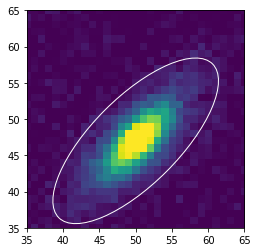

In [37]:
imgdata = image_r[1].data
geometry = EllipseGeometry(x0=50, y0=47, sma=15, eps=0.6,
                           pa=45.*np.pi/180.)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
plt.imshow(imgdata, origin='lower',vmin = 0, vmax = 1)
aper.plot(color='white')

plt.xlim(35,65)
plt.ylim(35,65)

In [5]:
ellipse = Ellipse(imgdata, geometry)
isolist = ellipse.fit_image()

In [6]:
isolist.pa

array([0.        , 0.61702047, 0.6424181 , 0.66221406, 0.67694077,
       0.68986383, 0.73389777, 0.76372467, 0.76935121, 0.77514249,
       0.7796575 , 0.77862055, 0.78868831, 0.80860344, 0.814505  ,
       0.81739401, 0.82338363, 0.80892451, 0.78187912, 0.77865049,
       0.76625155, 0.77556498, 0.77915519, 0.7893218 , 0.80311138,
       0.81019478, 0.81926334, 0.81767661, 0.82406077, 0.82359978,
       0.79860431, 0.77527927, 0.75914602, 0.78121199, 0.78121199,
       0.78121199, 0.78539816, 0.72086149, 0.72086149, 0.78121199,
       0.78121199, 0.78121199])

(0.0, 1.1)

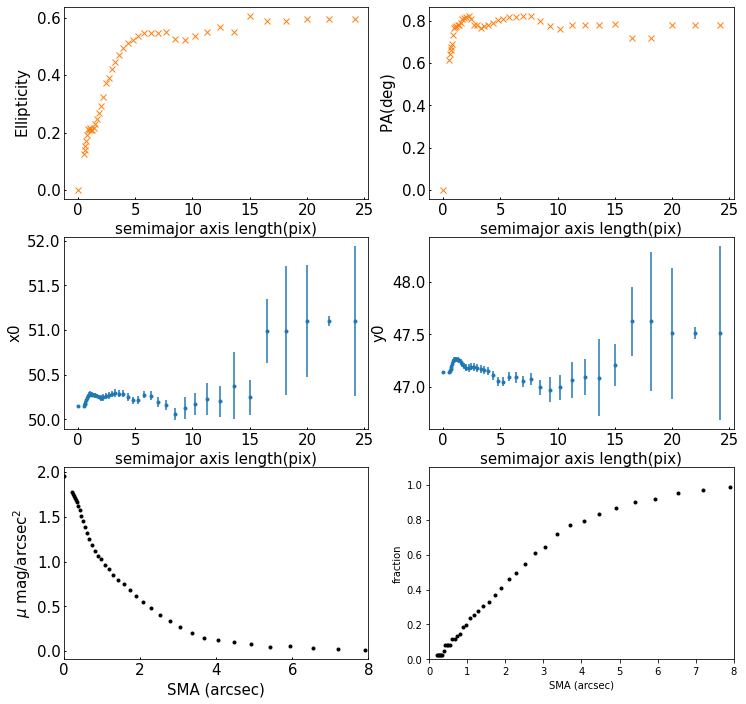

In [29]:
#### eps pa x0 y0
fig,axs = plt.subplots(3,2,figsize=(12,12))

axs[0,0].plot(isolist.sma, isolist.eps,'C1x')
axs[0,0].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
# axs[0,0].set_title(r'$\rm{Ellipticity}}$',fontsize=20)
axs[0,0].set_xlabel('semimajor axis length(pix)',fontsize=15)
axs[0,0].set_ylabel(r'$\rm{Ellipticity}}$',fontsize=15)

axs[0,1].plot(isolist.sma, isolist.pa, 'C1x')
axs[0,1].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
# axs[0,1].set_title(r'$\rm{PA}}$',fontsize=20)
axs[0,1].set_xlabel('semimajor axis length(pix)',fontsize=15)
axs[0,1].set_ylabel(r'$\rm{PA(deg)}}$',fontsize=15)

axs[1,0].errorbar(isolist.sma, isolist.x0, yerr = isolist.x0_err, fmt = 'C0.')
axs[1,0].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
# axs[1,0].set_title(r'$\rm{X}}$',fontsize=20)
axs[1,0].set_xlabel('semimajor axis length(pix)',fontsize=15)
axs[1,0].set_ylabel(r'$\rm{x0}}$',fontsize=15)

axs[1,1].errorbar(isolist.sma, isolist.y0, yerr = isolist.y0_err, fmt = 'C0.')
axs[1,1].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
# axs[1,1].set_title(r'$\rm{Y}}$',fontsize=20)
axs[1,1].set_xlabel('semimajor axis length(pix)',fontsize=15)
axs[1,1].set_ylabel(r'$\rm{y0}}$',fontsize=15)



kk = isolist.intens > 0 # 小于等于0的log没有意义
mu = -2.5*np.log10(isolist.intens[kk]/0.396**2) + 22.5 # 这里的zero point = 22.5
mu_err = 2.5*isolist.int_err[kk]/isolist.intens[kk]/np.log(10)

axs[2,0].errorbar(isolist.sma[kk]*0.396, isolist.intens[kk], yerr = isolist.int_err[kk], color='black', fmt='o', markersize=3)
axs[2,0].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
axs[2,0].set_xlabel('SMA (arcsec)',fontsize=15)
axs[2,0].set_ylabel('$\mu$ mag/arcsec$^2$',fontsize=15)
# axs[2,0].set_ylim(27,18)
axs[2,0].set_xlim(0,8)

cog = isolist.tflux_e/np.nanmax(isolist.tflux_e) # curve of growth，经常用来计算星系的size。
sma_cog = isolist.sma*0.396

axs[2,1].scatter(sma_cog, cog , color='black', marker='.')
axs[2,1].set_ylabel('fraction')
axs[2,1].set_xlabel('SMA (arcsec)')
axs[2,1].set_xlim(0, 8)
axs[2,1].set_ylim(0, 1.1)

In [20]:
R_e = np.interp(0.5, cog, sma_cog)

In [21]:
from astropy.cosmology import WMAP9 as cosmo
dist = cosmo.luminosity_distance(0.072).value*10**3  ## Kpc
kpc_per_arcsec = (1/2.06e5)*dist
R_e*kpc_per_arcsec

3.700224635260797

In [11]:
from scipy import optimize, signal

def sersic(r,*p):
    I_r = np.zeros_like(r)
    I_e = p[0]
    r_e = p[1]
    n   = p[2]
    b_n = 2*n-0.3
    I_r   += I_e * np.exp(-b_n * (((r/r_e) ** (1/n)) - 1 )) 
    return I_r 

def psf_func(r, amplitude=0, mean=0, stddev=0):
    return amplitude * np.exp(-(r-mean)**2/(2*stddev**2))

def psf_kernel(fwhm, r):
    sigma = fwhm/2.35
    return 1/(np.sqrt(2 * np.pi) * sigma) * np.exp(-r **2 / (2 * sigma ** 2))

def sersic_conv(r, *p, psf_fwhm = 1.26):
    if psf_fwhm:
        r_interp = np.linspace(r.min(), scale_factor*r.max(), points)
        flux = np.exp(sersic(r_interp, *p))
        psf = psf_kernel(psf_fwhm, r_interp[1]-r_interp[0])
        flux_sym = np.array([flux[::-1], flux]).flatten()
        flux_conv = signal.fftconvolve(flux_sym, psf, mode='same')
        return np.interp(r, r_interp, np.log(flux_conv[len(flux_sym)//2:]))
    return fmodel(x, r)

In [12]:
psf_fwhm_pix = 3.2
psf_fwhm_arcsec = psf_fwhm_pix * 0.396

kk         = isolist.sma < 20
intens     = isolist.intens[kk][1:]/0.396**2
intens_err = isolist.int_err[kk][1:]/0.396**2
radius     = isolist.sma[kk][1:] * 0.396

I_max = intens.max()
r_max = radius.max()
I_max, r_max

(11.361590969892246, 7.9061400000000015)

In [22]:
p0 = np.array([2, 1, 1])
bounds = ([0, 0.01, 0],[np.inf, 20, 4])

p, perr = curve_fit(sersic, radius, intens, p0=p0, bounds=bounds,
                    sigma=intens_err, absolute_sigma=True, maxfev=10000)

print('         Re              error                   PSF')
p[1] * kpc_per_arcsec, perr[1,1] * kpc_per_arcsec, psf_fwhm_arcsec * kpc_per_arcsec

         Re              error                   PSF


(4.2317817802146225, 0.00037212433299756045, 2.02108900293168)

In [27]:
p

array([2.2292599 , 2.65327943, 1.04688858])

In [58]:
from scipy.special import gamma
n = 1.0468
b = 2*n-0.3
I_e = 2.2292599
r_e = 14.231781

h = r_e/b**n
f_a = (n*gamma(2*n)*np.exp(b))/(b**(2*n))
b_d = f_a * (b**(2*n)) * (np.exp(-b))
f_a

1.931986867904416

In [59]:
b**(2*n)

3.397816384537131

In [ ]:
# 2.34*0.396* kpc_per_arcsec

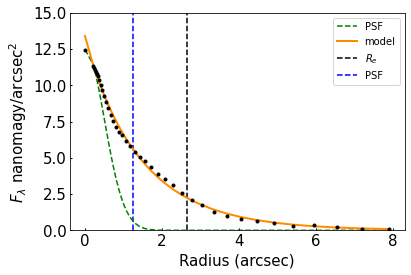

In [33]:
gauss_psf = psf_func(radius, amplitude=intens.max(), mean=0, stddev=1.2/2.35482)
gg_fit1 = sersic(radius, *p)

plt.errorbar(radius, intens, yerr = intens_err, color='black', fmt='o', markersize=3)
plt.tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
plt.plot(radius, gauss_psf, 'g--', label='PSF')
plt.plot(radius, gg_fit1, 'darkorange', lw = 2, label='model')
plt.vlines(x = p[1], ymin = 0, ymax = 100, colors = 'k', linestyles = 'dashed', label = "$R_{e}$")
plt.vlines(x = 1.26 , ymin = 0, ymax = 100, colors = 'b', linestyles = 'dashed',label = 'PSF')
    
plt.xlabel('Radius (arcsec)',fontsize=15)
plt.ylabel('$F_{\lambda}$ nanomagy/arcsec$^2$',fontsize=15)
plt.ylim(0, 15)
plt.legend()

In [9]:
from photutils.isophote import build_ellipse_model
model_image = build_ellipse_model(imgdata.shape, isolist)
residual = imgdata - model_image

(35.0, 65.0)

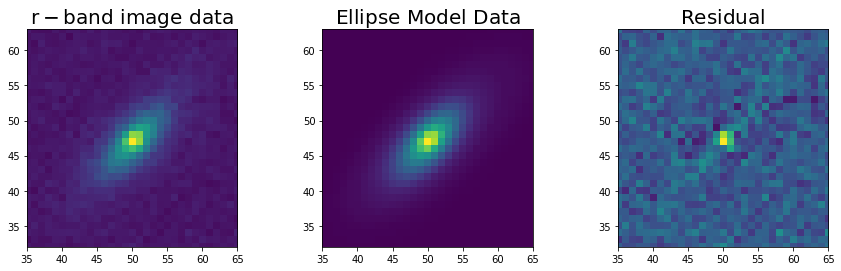

In [10]:
fig2,axs2 = plt.subplots(1,3,figsize=(15,4))

axs2[0].imshow(imgdata,origin='lower')
axs2[0].set_title(r'$\rm{r-band\ image\ data}$',fontsize=20)
axs2[0].set_ylim(32,63)
axs2[0].set_xlim(35,65)

axs2[1].imshow(model_image,origin='lower')
axs2[1].set_title(r'$\rm{Ellipse\ Model\ Data}$',fontsize=20)
axs2[1].set_ylim(32,63)
axs2[1].set_xlim(35,65)

axs2[2].imshow(residual,origin='lower')
axs2[2].set_title(r'$\rm{Residual}$',fontsize=20)
axs2[2].set_ylim(32,63)
axs2[2].set_xlim(35,65)

# smas = np.linspace(5, 25, 7)
# for sma in smas:
#     iso = isolist.get_closest(sma)
#     x, y, = iso.sampled_coordinates()
#     axs2[0].plot(x, y, color='C9')

In [526]:
R_e = np.interp(0.5, cog, sma_cog)
(R_e/0.2)*0.336

3.8975984796719287

## bulge

(35.0, 65.0)

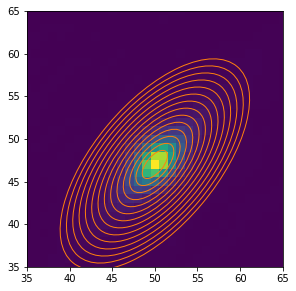

In [532]:
## image
from matplotlib.patches import Ellipse, Circle

sma_ain_b = np.arange(1,15)
sma_aout_b = np.arange(2,16)
sma_bin_b = sma_ain_b*0.48
sma_bout_b = sma_aout_b*0.48

fig = plt.figure(figsize=(18,16))
ax_fig_1 = plt.subplot(331)
ax_fig_1.imshow(imgdata_r_bulge, origin='lower')
for i in range(sma_aout_b.shape[0]):
    width_i = sma_aout_b[i]
    height_i = sma_bout_b[i]
    ell1 = Ellipse((50,47),width = (width_i)*2, height = (height_i)*2, 
                   angle = 50,linestyle = '-',edgecolor = 'C1',fc = 'none',lw = 1.0)
    ax_fig_1.add_patch(ell1)


plt.xlim(35,65)
plt.ylim(35,65)

In [533]:
sma_ain_b = np.arange(1,15)
sma_aout_b = np.arange(2,16)
sma_bin_b = sma_ain_b*0.48
sma_bout_b = sma_aout_b*0.48
phot_table_b = []
phot_rbulge_err = []
area_b = []
for i in range(sma_aout_b.shape[0]):
    a_in = sma_ain_b[i]
    a_out = sma_aout_b[i]
    b_in = sma_bin_b[i]
    b_out = sma_bout_b[i]
    
    aperture_r = EllipticalAnnulus((50,47), a_in, a_out, b_out,theta=50*np.pi/180)
    phot_table_i = aperture_photometry(imgdata_r_bulge, aperture_r)
    phot_i = np.array(phot_table_i['aperture_sum'])
    phot_table_b.append(phot_i)
    
    phot_err_r = aperture_photometry(imgdata_r_bulge_err**2, aperture_r)
    photrb_err = (np.array(phot_err_r['aperture_sum']))**0.5
    phot_rbulge_err.append(photrb_err)
    
    area_ii = np.pi*(a_out**2 - a_in**2)
    area_b.append(area_ii)
    
phot_table_b = np.array(phot_table_b).flatten()
phot_rbulge_err = np.array(phot_rbulge_err).flatten()
area_b = np.array(area_b)

Text(0.5, 0, '${\\rm R\\ [Kpc]}$')

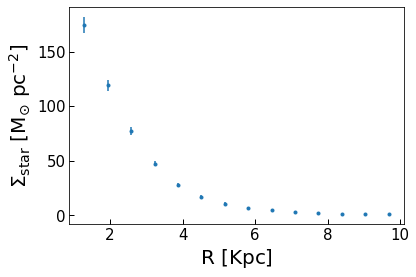

In [666]:
dist = 335.8                         ## Mpc

mag_rband_b = 22.5-2.5*np.log10(phot_table_b)   ## AB mag
mag_r_abs_b = mag_rband_b  - 5*np.log10(dist*10**6/10.)  ## r-band absolute AB mag
mag_rband_berr  = 2.5/np.log(10.0)*phot_rbulge_err/phot_table_b

lg_bM = 1.13+1.49*0.8-mag_r_abs_b/2.5
lg_bM_err = np.sqrt((mag_rband_berr/2.5)**2)
M_star_b = 10**lg_bM
Mass_err = np.sqrt((M_star_b*lg_bM_err*np.log(10))**2)

# arc_pixel_r = np.abs(head_r['CD1_1']*3600.0) #arcsec/pixel
arc_pixel_r = 0.396
area_pc2_r_b  = area_b*((arc_pixel_r/2.06e5)*dist*1.0e6)**2  ## pc2
area_sr2_r_b  = area_b*(arc_pixel_r/2.06e5)**2  ## sr2

SD_star_r_b = M_star_b/area_pc2_r_b          ## M_sun/pc2
SD_star_r_b_error = Mass_err/area_pc2_r_b
rad_kpc_r_b = sma_aout_b*(arc_pixel_r/2.06e5)*dist*1.0e3    #  kpc
plt.errorbar(rad_kpc_r_b,SD_star_r_b,yerr = SD_star_r_b_error,fmt = 'C0.') 

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm \Sigma_{star} \ [M_{\odot} \ pc^{-2}]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)

In [102]:
bulge_flux = np.sum(phot_table_b)
bulge_ferr = np.sqrt(np.sum(bulge_ferr**2))
disc_flux = np.sum(phot_table_r[:6])
disc_ferr = np.sqrt(np.sum(phot_r_error[:6]**2))

B_D = bulge_flux/disc_flux
B_D_err = np.sqrt((bulge_ferr/bulge_flux)**2+(disc_ferr/disc_flux)**2)
B_D,B_D_err

(0.2668804318347296, 0.027870901413205338)

## disc

(32.0, 68.0)

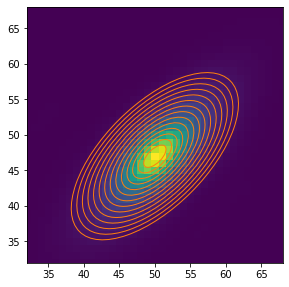

In [535]:
## image
from matplotlib.patches import Ellipse, Circle

sma_ain = np.arange(1,15)
sma_aout = np.arange(2,16)
sma_bin = sma_ain*0.48
sma_bout = sma_aout*0.48

fig = plt.figure(figsize=(18,16))
ax_fig_1 = plt.subplot(331)
ax_fig_1.imshow(image_r_disc, origin='lower')
for i in range(sma_aout.shape[0]):
    width_i = sma_aout[i]
    height_i = sma_bout[i]
    ell1 = Ellipse((50,47),width = (width_i)*2, height = (height_i)*2, 
                   angle = 45,linestyle = '-',edgecolor = 'C1',fc = 'none',lw = 1.0)
    ax_fig_1.add_patch(ell1)

plt.xlim(32,68)
plt.ylim(32,68)

In [536]:
sma_ain = np.arange(1,15)
sma_aout = np.arange(2,16)
sma_bin = sma_ain*0.48
sma_bout = sma_aout*0.48
phot_table_r = []
phot_r_error = []
phot_table_g = []
phot_g_error = []
area_r = []
for i in range(sma_aout.shape[0]):
    a_in = sma_ain[i]
    a_out = sma_aout[i]
    b_in = sma_bin[i]
    b_out = sma_bout[i]
    
    aperture_g = EllipticalAnnulus((49,49), a_in, a_out, b_out,theta=45*np.pi/180)
    phot_table_gi = aperture_photometry(image_g_disc, aperture_g)
    photg = np.array(phot_table_gi['aperture_sum'])
    phot_table_g.append(photg)
    
    phot_err_g = aperture_photometry(imgdata_g_err**2, aperture_g)
    photg_err = (np.array(phot_err_g['aperture_sum']))**0.5
    phot_g_error.append(photg_err)
    
    aperture_r = EllipticalAnnulus((50,47), a_in, a_out, b_out,theta=45*np.pi/180)
    phot_table_i = aperture_photometry(image_r_disc, aperture_r)
    phot_i = np.array(phot_table_i['aperture_sum'])
    phot_table_r.append(phot_i)
    
    phot_err_r = aperture_photometry(imgdata_r_err**2, aperture_r)
    photrb_err = (np.array(phot_err_r['aperture_sum']))**0.5
    phot_r_error.append(photrb_err)
    
    area_ii = np.pi*(a_out**2 - a_in**2)
    area_r.append(area_ii)
    
phot_table_r = np.array(phot_table_r).flatten()
phot_r_error = np.array(phot_r_error).flatten()
phot_table_g = np.array(phot_table_g).flatten()
phot_g_error = np.array(phot_g_error).flatten()
area_r = np.array(area_r)

In [537]:
dist = 335.8                         ## Mpc

mag_rband = 22.5 - 2.5*np.log10(phot_table_r)   ## AB mag
mag_rband_err  = 2.5/np.log(10.0)*phot_r_error/phot_table_r
mag_gband = 22.5 - 2.5*np.log10(phot_table_g)  
mag_gband_err  = 2.5/np.log(10.0)*phot_g_error/phot_table_g
mag_r_abs = mag_rband - 5*np.log10(dist*10**6/10.)  ## r-band absolute AB mag
mag_r_abs_err = mag_rband_err

M_star = np.full_like(mag_r_abs,0)
M_star_err = np.full_like(mag_r_abs,0)
for i in range(mag_rband.shape[0]):
    g_r = mag_gband[i] - mag_rband[i]
    g_r_err = np.sqrt(mag_gband_err[i]**2 + mag_rband_err[i]**2)
    if g_r < 0.1:
        g_r = 0.1
    elif g_r > 0.9:
        g_r = 0.9
    lg_M = 1.13+1.49*g_r-mag_r_abs[i]/2.5
    lg_M_err = np.sqrt((1.49*g_r_err)**2 + (mag_r_abs_err[i]/2.5)**2)
    Mass = 10**lg_M
    Mass_err = np.sqrt((Mass*lg_M_err*np.log(10))**2)
    M_star[i] = Mass
    M_star_err[i] = Mass_err

arc_pixel_r=0.396
area_pc2_r  = area_r*((arc_pixel_r/2.06e5)*dist*1.0e6)**2  ## pc2
area_sr2_r  = area_r*(arc_pixel_r)**2  ## sr2

SD_star_r = M_star/area_pc2_r          ## M_sun/pc2
SD_star_error = M_star_err/area_pc2_r

SD_mag_r = mag_rband/area_sr2_r
SD_mag_r_err = mag_rband_err/area_sr2_r

rad_kpc_r = sma_aout*(arc_pixel_r/2.06e5)*dist*1.0e3    #  kpc
area_r.shape

(14,)

Text(0.5, 0, '${\\rm R\\ [Kpc]}$')

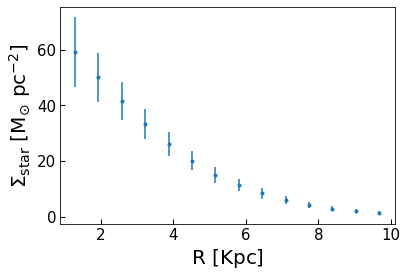

In [538]:
# plt.plot(rad_kpc_r,SD_star_r,'.')    ###    stelllar surface density
plt.errorbar(rad_kpc_r,SD_star_r,yerr = SD_star_error,fmt = 'C0.')    ###   brightness profile

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm \Sigma_{star} \ [M_{\odot} \ pc^{-2}]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)

In [88]:
np.sum(M_star)+np.sum(M_star_b),np.sum(M_star_err)+np.sum(Mass_err)

(5144858926.585491, 641889087.0994611)

In [245]:
# total mass
np.log10(4.74*10**9)

9.675778341674086

## total

(35.0, 65.0)

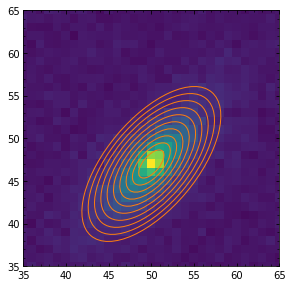

In [478]:
## image
from matplotlib.patches import Ellipse, Circle
fig = plt.figure(figsize=(18,16))
ax_fig_1 = plt.subplot(331)
ax_fig_1.imshow(image_tol, origin='lower')
for i in range(sma_aout.shape[0]):
    width_i = sma_aout[i]5
    height_i = sma_bout[i]
    ell1 = Ellipse((50,47),width = (width_i)*2, height = (height_i)*2, 
                   angle = 50,linestyle = '-',edgecolor = 'C1',fc = 'none',lw = 1.0)
    ax_fig_1.add_patch(ell1)


plt.xlim(35,65)
plt.ylim(35,65)

In [479]:
sma_ain = np.arange(1,12)
sma_aout = np.arange(2,13)
sma_bin = sma_ain*0.48
sma_bout = sma_aout*0.48
phot_table = []
area= []
for i in range(sma_aout.shape[0]):
    a_in = sma_ain[i]
    a_out = sma_aout[i]
    b_in = sma_bin[i]
    b_out = sma_bout[i]
    
    aperture_r = EllipticalAnnulus((50,47), a_in, a_out, b_out,theta=50*np.pi/180)
    phot_table_i = aperture_photometry(image_tol, aperture_r)
    phot_i = np.array(phot_table_i['aperture_sum'])
    phot_table.append(phot_i)
    
    area_ii = np.pi*(a_out**2 - a_in**2)
    area.append(area_ii)
    
phot_table = np.array(phot_table).flatten()
area = np.array(area)

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

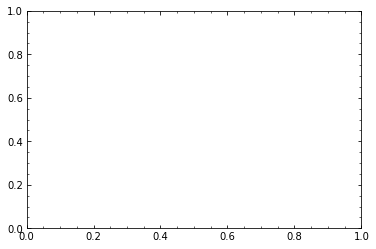

In [481]:
dist = 335.8                         ## Mpc
mag_rband = 22.5 - 2.5*np.log10(phot_table/0.396**2)   ## AB mag

plt.plot(rad_kpc_r,mag_rband, 'C0.')    ###   brightness profile

In [484]:
rad_kpc_r

array([1.29103689, 1.93655534, 2.58207379, 3.22759223, 3.87311068,
       4.51862913, 5.16414757, 5.80966602, 6.45518447, 7.10070291])

In [244]:
np.log10(4.74*10**9)

9.675778341674086

### surface brightness profile fit

In [14]:
from scipy.optimize import curve_fit

In [15]:
def dva_law(r,*p):
    f = p[0]*np.exp(-7.67*((r/p[1])**(1/p[2])-1))
    return f

p0 = np.asarray([6,4,1])
p0_bounds = np.asarray([[0,0,0],[SD_mag_r[0],rad_kpc_r[-1],4]])
popt,pocv = curve_fit(dva_law,rad_kpc_r,SD_mag_r,p0=p0,bounds=p0_bounds)
print(popt)

[0.90732412 7.74622136 4.        ]


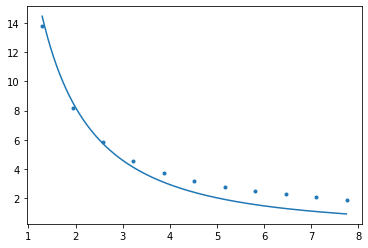

In [16]:
plt.errorbar(rad_kpc_r,SD_mag_r,yerr = SD_mag_r_err,fmt = 'C0.')    ###   brightness profile
fake_x = np.arange(rad_kpc_r[0],rad_kpc_r[-1],0.01)
plt.plot(fake_x,dva_law(fake_x,*popt))

9.675778341674086

## 保存数据

In [539]:
# d_mass = np.pad(SD_star_r_b,(0,8),'constant',constant_values=(0,0))
SD_bulge = np.around(SD_star_r_b, decimals=4)
# d_mass_err = np.pad(SD_star_r_b_error,(0,8),'constant',constant_values=(0,0))
SD_bulge_err = np.around(SD_star_r_b_error, decimals=4)

SD_disc = np.around(SD_star_r, decimals=4)
SD_disc_err = np.around(SD_star_error, decimals=4)

SD_radius = np.around(rad_kpc_r, decimals=4)

SD_total = SD_bulge+SD_disc
SD_total_err = np.sqrt(SD_bulge_err**2 + SD_disc_err**2)

In [662]:
SD_star_r_b_error

array([7.61753734, 4.9147604 , 3.39016339, 2.39344764, 1.73523644,
       1.31447791, 1.04592018, 0.86682872, 0.74215389, 0.65993086,
       0.60069225,        nan,        nan,        nan])

In [540]:
rdd=Table({'R(kpc)':SD_radius,
           'density_bulge':SD_bulge,
           'density_bulge_error':SD_bulge_err,
           'density_disc':SD_disc,
           'density_disc_error':SD_disc_err,
           'density_total':SD_total,
           'density_total_error':SD_total_err,})
ascii.write(rdd,'data/Sigma_star_10kpc.txt',overwrite=1)

# SFR & Gas surface density

## SFR

In [457]:
Ha_region_data = fits.open('data/SDSSj0228_haregion_flux_rebin.fits')
dust_corr_data = fits.open("Metallicity_Hcm5.1/SDSSJ0228_dustcorr_flux.fits")
ha_flux = dust_corr_data[3].data
ha_flux_err = Ha_region_data[2].data

dist = 335.8                         ## Mpc
mpc_cm = 3.0856776 * 10**(24)
flux_Ha = ha_flux * (4*np.pi*(dist*mpc_cm)**2)               ## erg/s
flux_Ha_err = ha_flux_err * (4*np.pi*(dist*mpc_cm)**2)      ## erg/s
ha_snr = flux_Ha/flux_Ha_err

In [316]:
spec_rebin = fits.open("data/SDSSJ0228_rebin_specHa_10.fits")
spec_flux_rebin = spec_rebin[1].data
spec_err_rebin  = spec_rebin[2].data
spec_con_rebin  = spec_rebin[3].data

ppdata = fits.open("data/ppxf/SDSSJ0228_mask_ppxf_fitdata.fits")
pp_wave = ppdata[1].data["wavelength"]

ha_vmap = fits.open("data/SDSSJ0228_Ha_velocity.fits")
ha_vm_data = ha_vmap[1].data
(1.25/6563)*3*10**5

57.138503733048914

In [374]:
def stack_annu_spec(aper, spec_data, vmap):
    
    spec_flux = spec_data[1].data
    spec_err  = spec_data[2].data
    voff_data = vmap[1].data
    mask_aper = aper.to_mask(method='center')
    maper_yc = mask_aper.data.shape[0]//2+1
    maper_xc = mask_aper.data.shape[1]//2+1
    
    spec_annu = []
    serr_annu = []
    mask_spec = np.zeros((50,50))
    
    pix_num = 0
    for y in range(mask_aper.data.shape[0]):
        for x in range(mask_aper.data.shape[1]):
            if mask_aper.data[y,x] == 1:
                pix_num += 1
                dy = y - maper_yc
                dx = x - maper_xc
                x_ha = 25 + dx
                y_ha = 25 + dy
                mask_spec[y_ha,x_ha] = 1
                
    for yi in range(mask_spec.shape[0]):
        for xi in range(mask_spec.shape[1]):
            if mask_spec[yi,xi] == 1:
                spec_annu_i = spec_flux[:,yi,xi]
                serr_annu_i = spec_err[:,yi,xi]
                voff = voff_data[yi,xi]
                
                if -4.5<voff/57<-3.5:
                    spec_ai_new = np.append(np.array([0,0,0,0]),spec_annu_i[:-4])
                    serr_ai_new = np.append(np.array([0,0,0,0]),serr_annu_i[:-4])
                elif -3.5<voff/57<-2.5:
                    spec_ai_new = np.append(np.array([0,0,0]),spec_annu_i[:-3])
                    serr_ai_new = np.append(np.array([0,0,0]),serr_annu_i[:-3])
                elif -2.5<voff/57<-1.5:
                    spec_ai_new = np.append(np.array([0,0]),spec_annu_i[:-2])
                    serr_ai_new = np.append(np.array([0,0]),serr_annu_i[:-2])
                elif -1.5<voff/57<-0.5:
                    spec_ai_new = np.append(np.array([0]),spec_annu_i[:-1])
                    serr_ai_new = np.append(np.array([0]),serr_annu_i[:-1])
                elif -0.5<voff/57<0.5:
                    spec_ai_new = spec_annu_i
                    serr_ai_new = serr_annu_i
                elif 0.5<voff/57<1.5:
                    spec_ai_new = np.append(spec_annu_i[1:],np.array([0]))
                    serr_ai_new = np.append(serr_annu_i[1:],np.array([0]))
                elif 1.5<voff/57<2.5:
                    spec_ai_new = np.append(spec_annu_i[2:],np.array([0,0]))
                    serr_ai_new = np.append(serr_annu_i[2:],np.array([0,0]))
                elif 2.5<voff/57<3.5:
                    spec_ai_new = np.append(spec_annu_i[3:],np.array([0,0,0]))
                    serr_ai_new = np.append(serr_annu_i[3:],np.array([0,0,0]))    
                elif 3.5<voff/57<4.5:
                    spec_ai_new = np.append(spec_annu_i[4:],np.array([0,0,0,0]))
                    serr_ai_new = np.append(serr_annu_i[4:],np.array([0,0,0,0])) 
                

                spec_annu.append(spec_ai_new)
                serr_annu.append(serr_ai_new)
                
    spec_annu_stack = np.array(np.sum(spec_annu, axis=0))
    spec_annu_stack_err = np.sqrt(np.sum(np.array(serr_annu)**2, axis=0))
    
    return pix_num, spec_annu_stack, spec_annu_stack_err

In [375]:
aperture_ha = EllipticalAnnulus((25,25), 16, 18, 18*0.48,theta=90*np.pi/180)
pix, spec_annu_stack,spec_annu_stack_err = stack_annu_spec(aperture_ha, spec_rebin, ha_vmap)

In [546]:
sma_ha_ain = np.arange(10,25,2)
sma_ha_aout = np.arange(12,27,2)
sma_ha_bin = sma_ha_ain*0.48
sma_ha_bout = sma_ha_aout*0.48

annu_pixnum = []
stack_annuspec = []
stack_annuerr  = []
aera = []
for i in range(sma_ha_aout.shape[0]):
    a_in  = sma_ha_ain[i]
    a_out = sma_ha_aout[i]
    b_out = sma_ha_bout[i]
    
    area_i = np.pi*(a_out**2 - a_in**2)
    aperture_ha = EllipticalAnnulus((25,25), a_in, a_out, b_out,theta=90*np.pi/180)
    pix_num, stack_spec, stack_serr = stack_annu_spec(aperture_ha, spec_rebin, ha_vmap)
    
    aera.append(area_i)
    annu_pixnum.append(pix_num)
    stack_annuspec.append(stack_spec)
    stack_annuerr.append(stack_serr)

In [548]:
SD_radius,sma_ha_ain

(array([1.291 , 1.9366, 2.5821, 3.2276, 3.8731, 4.5186, 5.1641, 5.8097,
        6.4552, 7.1007, 7.7462, 8.3917, 9.0373, 9.6828]),
 array([10, 12, 14, 16, 18, 20, 22, 24]))

In [555]:
aa = np.array([6.4552, 7.1007, 7.7462, 8.3917])

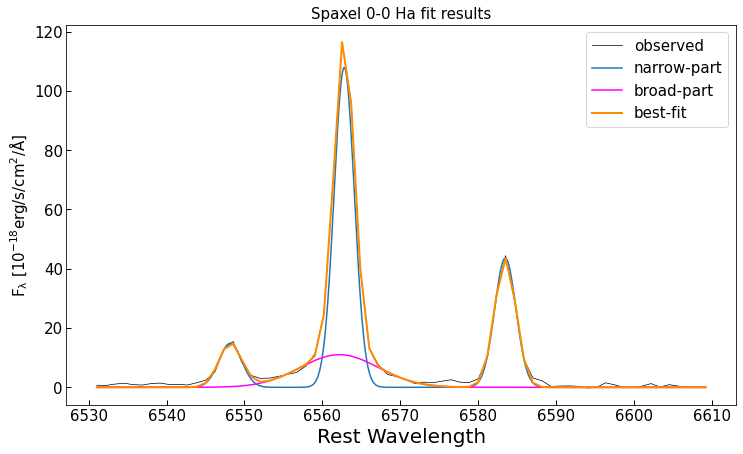

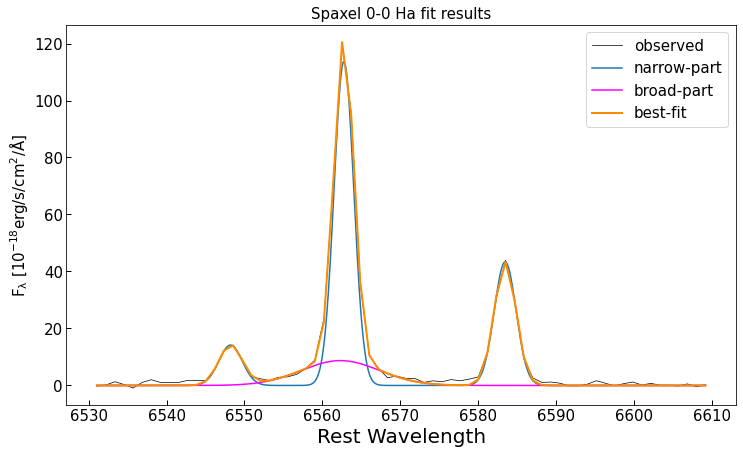

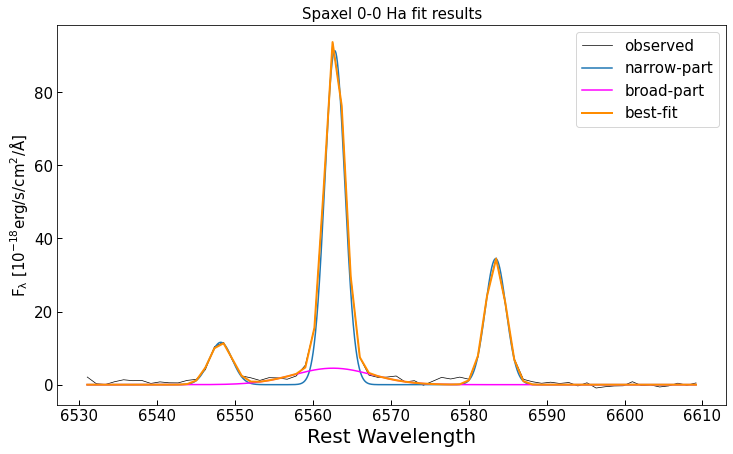

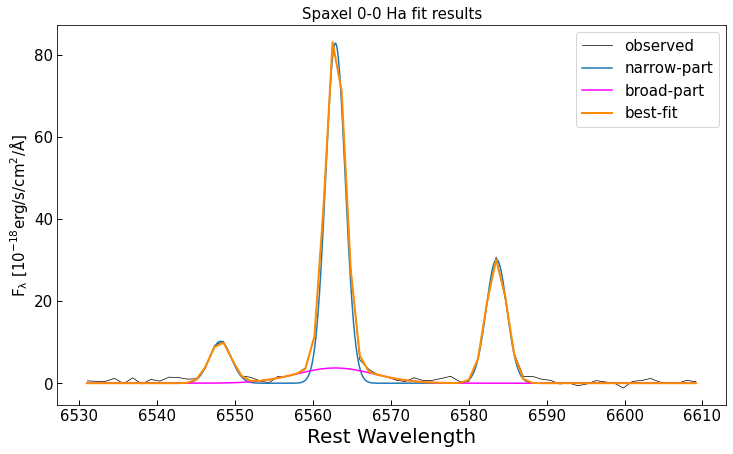

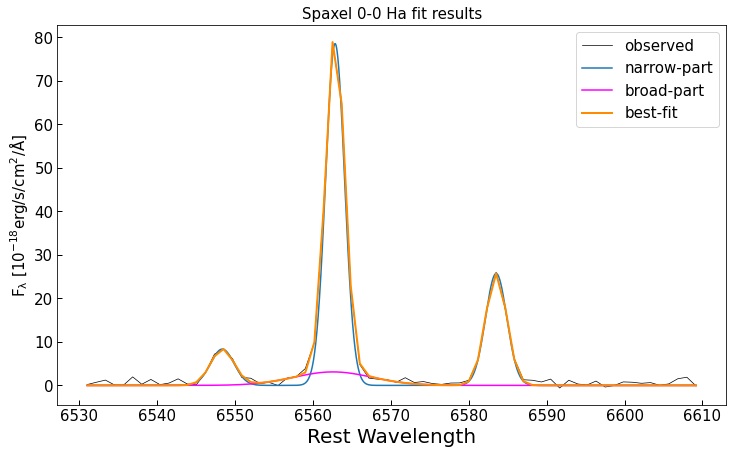

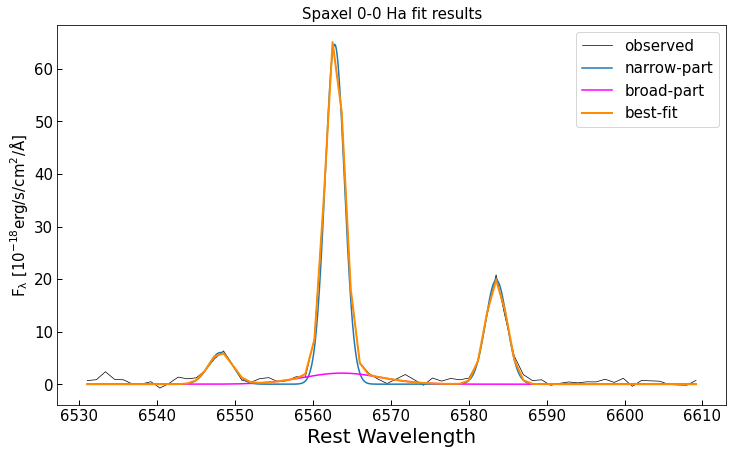

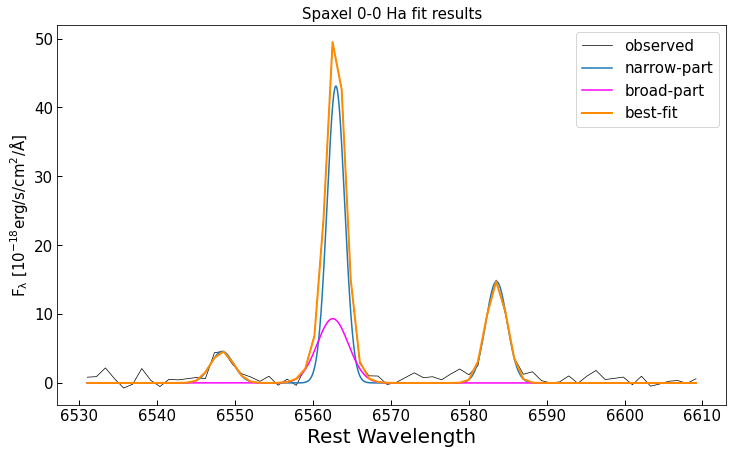

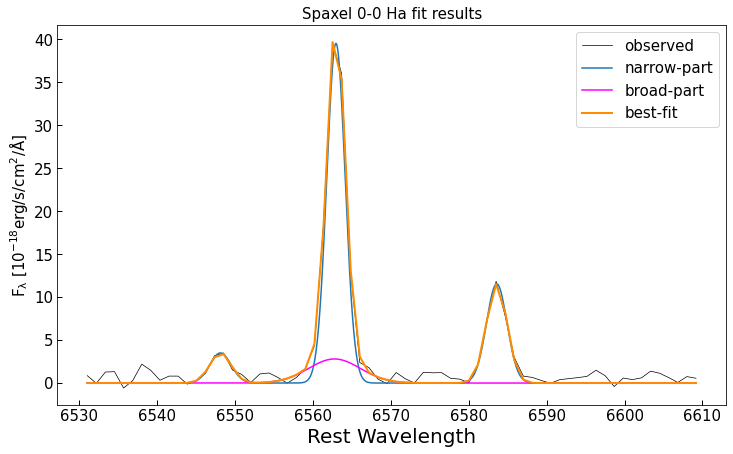

In [551]:
from pkg import spec_fit
spec_con = np.full_like(stack_annuspec[0],0)
F_ha_annu = []
F_ha_annu_err = [] 
for i in range(len(aera)):
    STATUS_ha,KINEM_ha = spec_fit.emline_fit(pp_wave,stack_annuspec[i],stack_annuerr[i],spec_con,mode ='Ha', plot=True)
    flux_Ha = KINEM_ha["Ha[6563]_flux"]
    flux_Haerr = KINEM_ha["Ha[6563]_fluxerr"]
    F_ha_annu.append(flux_Ha)
    F_ha_annu_err.append(flux_Haerr)

In [552]:
L_Ha_new = np.array(F_ha_annu)*10**(-20)*(4*np.pi*(dist*mpc_cm)**2)
L_Ha_new_err = np.array(F_ha_annu_err)*10**(-20)*(4*np.pi*(dist*mpc_cm)**2) 
SFR_new = 7.9*10**(-42)*L_Ha_new
SFR_new_err = 7.9*10**(-42)*L_Ha_new_err
SFR_D = SFR_new/(np.array(aera)*((0.2/2.06e5)*dist*1.0e3)**2)
SFR_D_err = SFR_new_err/(np.array(aera)*((0.2/2.06e5)*dist*1.0e3)**2)

In [553]:
SFR_new.shape

(8,)

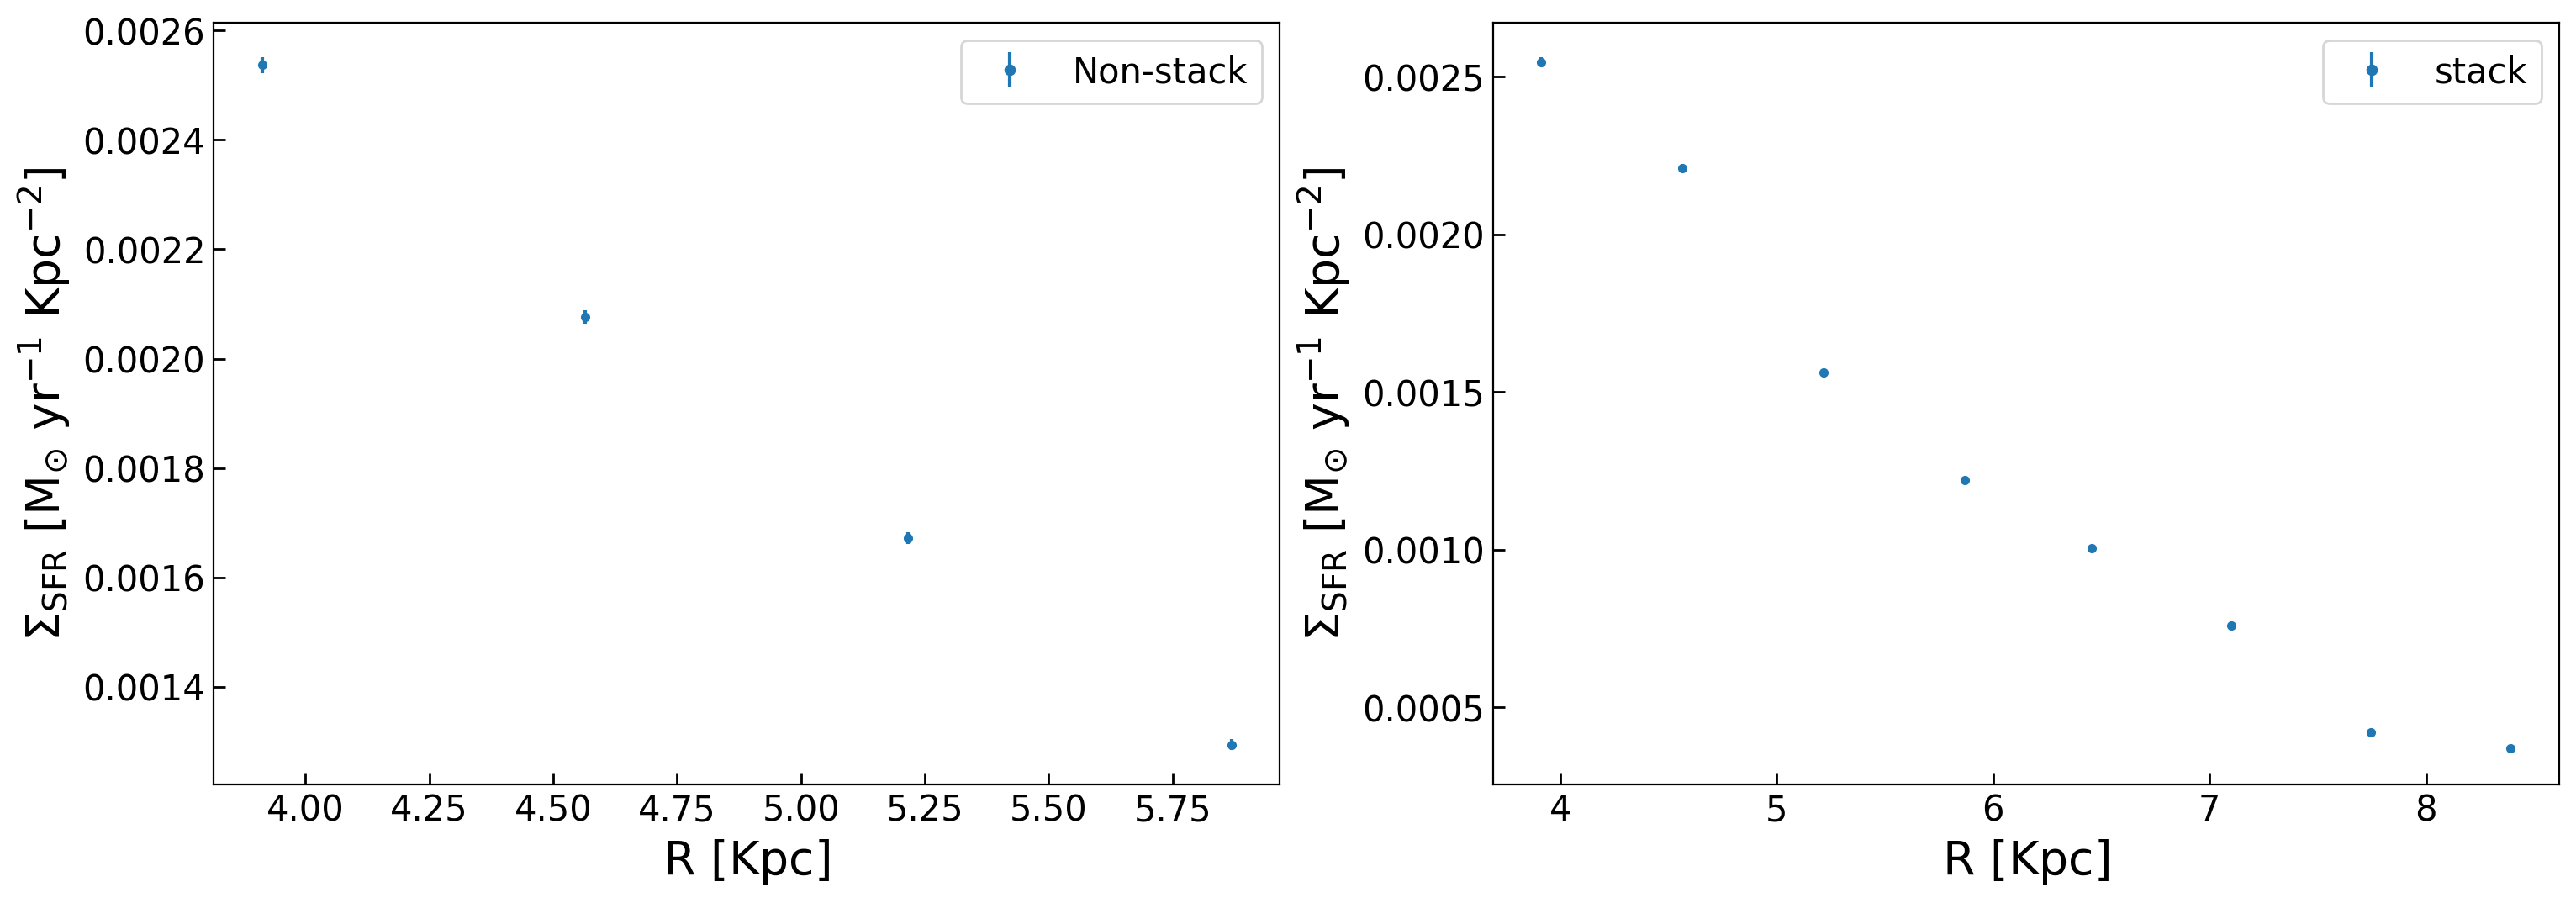

In [556]:
fig = plt.figure(figsize=(18,6),dpi = 200)
ax1 = plt.subplot(121)
plt.errorbar(rad_kpc_ha,SD_sfr,yerr = SD_sfr_err,fmt='.',label='Non-stack')
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm \Sigma_{SFR} \ [M_{\odot} \ yr^{-1} \ Kpc^{-2}]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
plt.legend(fontsize = 15.0,markerscale = 1.3)

ax1 = plt.subplot(122)
plt.errorbar(np.append(rad_kpc_ha,aa),SFR_D,yerr = SFR_D_err,fmt='.',label='stack')
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm \Sigma_{SFR} \ [M_{\odot} \ yr^{-1} \ Kpc^{-2}]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
plt.legend(fontsize = 15.0,markerscale = 1.3)

In [356]:
### image
# from matplotlib.patches import Ellipse, Circle
# fig = plt.figure(figsize=(18,16))
# ax_fig_1 = plt.subplot(331)
# # ax_fig_1.imshow(flux_Ha, origin='lower')
# ax_fig_1.imshow(ha_flux/ha_flux_err,vmin = 6)
# for i in range(sma_ha_aout.shape[0]):
#     width_i = sma_ha_ain[i]
#     height_i = sma_ha_bin[i]
#     ell1 = Ellipse((25,25),width = (width_i)*2, height = (height_i)*2, 
#                    angle = 90,linestyle = '-',edgecolor = 'C1',fc = 'none',lw = 1.0)
#     ax_fig_1.add_patch(ell1)

# ax2 = plt.subplot(332)
# ma_ha_snr = ha_snr[:,25]
# r_x = np.arange(-25*0.326,25*0.326,0.326)
# rxp = np.arange(-25,25,1) 
# ax2.plot(rxp,ma_ha_snr,'.')
# ax2.set_ylabel(r'${\rm S/N_{H\alpha}}$')
# ax2.set_xlabel(r'${\rm \delta pix}$')

In [458]:
sma_ha_ain = np.arange(10,17,2)
sma_ha_aout = np.arange(12,19,2)
sma_ha_bin = sma_ha_ain*0.48
sma_ha_bout = sma_ha_aout*0.48
phot_Ha = []
phot_Ha_err = []
area_Ha = []
for i in range(sma_ha_aout.shape[0]):
    a_in  = sma_ha_ain[i]
    a_out = sma_ha_aout[i]
    b_in  = sma_ha_bin[i]
    b_out = sma_ha_bout[i]
    
    aperture_ha = EllipticalAnnulus((25,25), a_in, a_out, b_out,theta=90*np.pi/180)
    phot_table_i = aperture_photometry(flux_Ha, aperture_ha)
    phot_i = np.array(phot_table_i['aperture_sum'])
    phot_Ha.append(phot_i)
    
    phot_err_i = aperture_photometry(flux_Ha_err**2, aperture_ha)
    phot_err = (np.array(phot_err_i['aperture_sum']))**0.5
    phot_Ha_err.append(phot_err)
    
    
    area_ii = np.pi*(a_out**2 - a_in**2)
    area_Ha.append(area_ii)
    
phot_Ha = np.array(phot_Ha).flatten() * 10**(-20)   #### erg*s(-1)
phot_Ha_err = np.array(phot_Ha_err).flatten() * 10**(-20)   #### erg*s(-1)
area_Ha = np.array(area_Ha) 

In [463]:
dist = 335.8                         ## Mpc
arc_pixel_ha=0.2                     ## aecsec/pix
area_pc2_Ha  = area_Ha*((arc_pixel_ha/2.06e5)*dist*1.0e3)**2  ## kpc2
rad_kpc_ha = sma_ha_aout*(arc_pixel_ha/2.06e5)*dist*1.0e3    #  kpc

sfr = 7.9*10**(-42)*phot_Ha          ## SFR M_sun/yr
sfr_err = 7.9*10**(-42)*phot_Ha_err
SD_sfr = sfr/area_pc2_Ha             ## M_sun/yr/kpc2
SD_sfr_err = sfr_err/area_pc2_Ha

# plt.errorbar(rad_kpc_ha,SD_sfr,yerr = SD_sfr_err,fmt='.')
# plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
# plt.ylabel(r'${\rm \Sigma_{SFR} \ [M_{\odot} \ yr^{-1} \ Kpc^{-2}]}$',fontsize=20)
# plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)

In [561]:
SD_radius[:-2]

array([1.291 , 1.9366, 2.5821, 3.2276, 3.8731, 4.5186, 5.1641, 5.8097,
       6.4552, 7.1007, 7.7462, 8.3917])

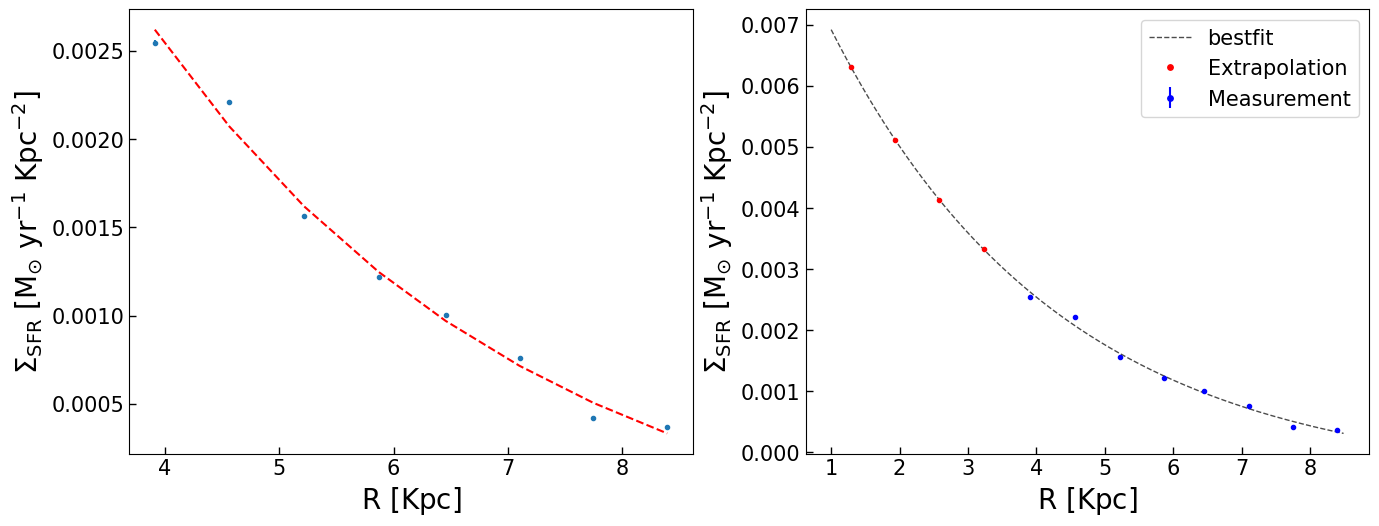

In [569]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

r_fit = np.append(rad_kpc_ha,aa)
xdata = r_fit
ydata = SFR_D
yerror = SFR_D_err

popt, pcov = curve_fit(func, xdata, ydata,sigma=yerror, absolute_sigma=True)
y2 = [func(i, popt[0],popt[1],popt[2]) for i in xdata]

fig = plt.figure(figsize=(16,20),dpi = 100)
ax1 = plt.subplot(321)
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax1.errorbar(r_fit,SFR_D,yerr = SFR_D_err,fmt='.')
ax1.plot(xdata,y2,'r--')
ax1.set_ylabel(r'${\rm \Sigma_{SFR} \ [M_{\odot} \ yr^{-1} \ Kpc^{-2}]}$',fontsize=20)
ax1.set_xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)

ax2 = plt.subplot(322)

fakex = np.arange(1.0,8.5,0.01)
fakey = [func(i, popt[0],popt[1],popt[2]) for i in fakex]
ax2.plot(fakex,fakey,'k--',lw = 1.0, alpha = 0.7, label= "bestfit")

xx = SD_radius[:-2]
yy = [func(i, popt[0],popt[1],popt[2]) for i in xx]
ax2.plot(xx[:4],yy[:4],'.',color='red',label="Extrapolation")

ax2.errorbar(r_fit,SFR_D,yerr = SFR_D_err,fmt='.',color='blue', label="Measurement")

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax2.set_ylabel(r'${\rm \Sigma_{SFR} \ [M_{\odot} \ yr^{-1} \ Kpc^{-2}]}$',fontsize=20)
ax2.set_xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
# ax2.set_xlim(0.7,6)
plt.legend(fontsize = 15.0,markerscale = 1.3)

In [686]:
popt

array([ 0.00997753,  0.29870517, -0.00048096])

In [577]:
SFR_dendity_ep = np.append(yy[:4],SFR_D)
SFR_dendity_ep_err = np.append(0.01*np.array(yy[:4]),SFR_D_err)
SFR_dendity_disc = np.append([0,0,0,0],SFR_D)
SFR_dendity_disc_err = np.append([0,0,0,0],SFR_D_err)

In [579]:
rdd=Table({'Radius':SD_radius[:-2],
           'SFR_dendity_ep':SFR_dendity_ep,
           'SFR_dendity_ep_err':SFR_dendity_ep_err,
           'SFR_dendity_disc':SFR_dendity_disc,
           'SFR_dendity_disc_err':SFR_dendity_disc_err,})
ascii.write(rdd,'data/Sigma_SFR_2model.txt',overwrite=1)

## Gas

In [641]:
SD_star = SD_total[:-2]
SD_total_error = SD_total_err[:-2]
R_star = SD_radius[:-2]

lg_star = np.log10(SD_star)
lg_star_err = np.sqrt((SD_total_error/(SD_star*np.log(10)))**2)

SD_SFR_ep = SFR_dendity_ep
SD_SFR_ep_err =  SFR_dendity_ep_err
SD_SFR_disk = SFR_dendity_disc[4:]
SD_SFR_disk_err = SFR_dendity_disc_err[4:]

lg_SFR_ep = np.log10(SD_SFR_ep)
lg_sfr_ep_err = np.sqrt((SD_SFR_ep_err/(SD_SFR_ep*np.log(10)))**2)
lg_SFR_disk = np.log10(SD_SFR_disk)
lg_sfr_disk_err = np.sqrt((SD_SFR_disk_err/(SD_SFR_disk*np.log(10)))**2)

lg_gas_ep = lg_SFR_ep/1.09 - lg_star/2 + 4.76
lg_gas_ep_err = np.sqrt((SD_SFR_ep_err/1.09)**2 + (lg_star_err/2)**2 + (0.23)**2)

lg_gas_disk = lg_SFR_disk/1.09 - lg_star[4:]/2 + 4.76
lg_gas_disk_err = np.sqrt((lg_sfr_disk_err/1.09)**2 + (lg_star_err[4:]/2)**2 + (0.23)**2)

SD_gas_ep = 10**lg_gas_ep
SD_gas_ep_err = np.sqrt((np.log(10)*SD_gas_ep*lg_gas_ep_err)**2)

SD_gas_disk = 10**lg_gas_disk
SD_gas_disk_err = np.sqrt((np.log(10)*SD_gas_disk*lg_gas_disk_err)**2)

SD_gas_disk = np.append([0,0,0,0], SD_gas_disk)
SD_gas_disk_err = np.append([0,0,0,0], SD_gas_disk_err)


Text(0.5, 0, '${\\rm R\\ [Kpc]}$')

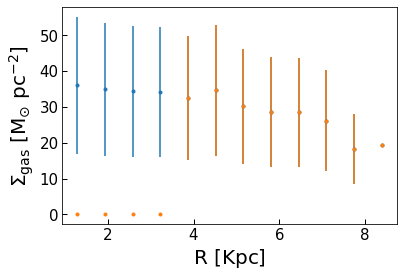

In [642]:
plt.errorbar(R_star,SD_gas_ep,yerr=SD_gas_ep_err,fmt='C0.')
plt.errorbar(R_star,SD_gas_disk,yerr=SD_gas_disk_err,fmt='C1.')
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm \Sigma_{gas} \ [M_{\odot} \ pc^{-2}]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)

In [643]:
###  保存数据
rdd=Table({'R':R_star,
           'SD_GAS_ep':SD_gas_ep,
           'SD_GAS_ep_err':SD_gas_ep_err,
           'SD_GAS_disk':SD_gas_disk,
           'SD_GAS_disk_err':SD_gas_disk_err,})
ascii.write(rdd,'data/gasmass_surface_density_2model.txt',overwrite=1)

# 作图

In [290]:
from astropy import wcs
wcs_new = wcs.WCS(naxis=2)
wcs_new.wcs.crpix = [25,25]
wcs_new.wcs.crval = np.array([37.20578573, -9.02983222])
wcs_new.wcs.cdelt = np.array([-5.55555555555556e-05, 5.55555555555556e-05]) #minus for left-east
wcs_new.wcs.ctype = ['RA---TAN', 'DEC--TAN']

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


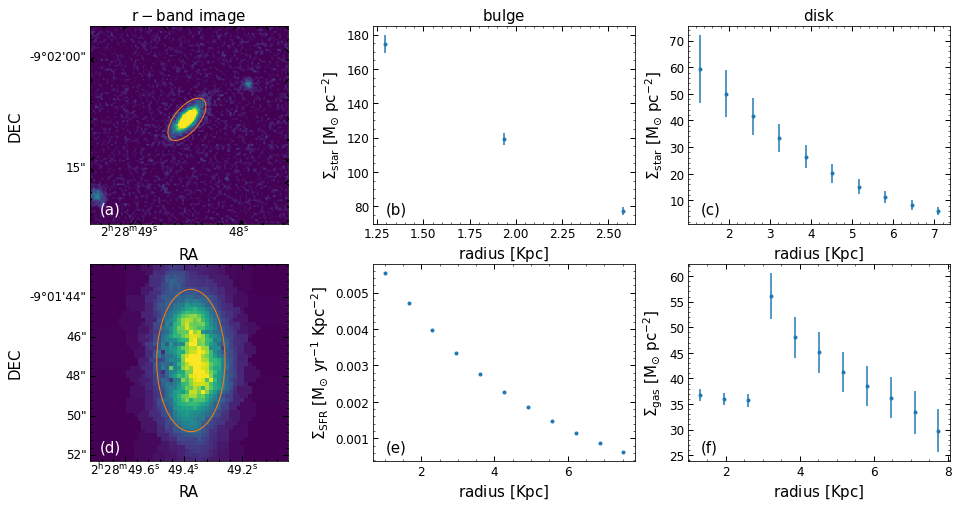

In [156]:
fig = plt.figure(figsize=(16,8))
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

fr_data = frame_r[0].data[1111:1136,1787:1812]
test_data = frame_r[0].data
wcs1= wcs.WCS(frame_r[0].header)

ax1 = fig.add_subplot(231, projection=wcs1)
ax1.imshow(test_data,origin='lower',vmin = 0,vmax=0.5)
ax1.text(0.05,0.05,'(a)',transform=ax1.transAxes,fontdict={'size': '15', 'color': 'white'})
ell1 = Ellipse((1799,1123),width = (13)*2, height = (13*0.48)*2, 
                   angle = 50,linestyle = '-',edgecolor = 'C1',fc = 'none',lw = 1.0)
ax1.add_patch(ell1)
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax1.set_xlabel('RA',fontsize = 15)
ax1.set_ylabel('DEC',fontsize = 15)
plt.title(r"${\rm r-band\ image}$",fontsize = 15)
plt.ylim(1070,1170)
plt.xlim(1750,1850)

ax2 = fig.add_subplot(232)

plt.errorbar(rad_kpc_r_b,SD_star_r_b,yerr = SD_star_r_b_error,fmt = 'C0.') 
ax2.text(0.05,0.05,'(b)',transform=ax2.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
plt.title(r'${\rm bulge}$',fontsize=15)
plt.ylabel(r'${\rm \Sigma_{star} \ [M_{\odot} \ pc^{-2}]}$',fontsize=15)
plt.xlabel(r'${\rm radius\ [Kpc]}$',fontsize=15)

ax3 = fig.add_subplot(233)

plt.errorbar(rad_kpc_r,SD_star_r,yerr = SD_star_error,fmt = 'C0.')    ###   brightness profile
ax3.text(0.05,0.05,'(c)',transform=ax3.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
plt.title(r'${\rm disk}$',fontsize=15)
plt.ylabel(r'${\rm \Sigma_{star} \ [M_{\odot} \ pc^{-2}]}$',fontsize=15)
plt.xlabel(r'${\rm radius\ [Kpc]}$',fontsize=15)

ax4 = fig.add_subplot(234, projection=wcs_new)

ax4.imshow(ha_flux,vmin = 10,vmax = 800,origin='lower')
ellha = Ellipse((25,25),width = (18)*2, height = (18*0.48)*2, 
                   angle = 90,linestyle = '-',edgecolor = 'C1',fc = 'none',lw = 1.0)

ax4.add_patch(ellha)
ax4.text(0.05,0.05,'(d)',transform=ax4.transAxes,fontdict={'size': '15', 'color': 'white'})
# Zm = Ellipse((25,25),width = (12)*2, height = (12*0.48)*2, 
#                    angle = 90,linestyle = '-',edgecolor = 'k',fc = 'none',lw = 0,hatch='//////')
# ax4.add_patch(Zm)

# ax4.pcolor(Zm, hatch='/', edgecolor='grey',facecolor='none', linewidth=0)

plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax4.set_xlabel('RA',fontsize = 15)
ax4.set_ylabel('DEC',fontsize = 15)

ax5 = fig.add_subplot(235)

plt.plot(xx,yy,'.')
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax5.text(0.05,0.05,'(e)',transform=ax5.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.ylabel(r'${\rm \Sigma_{SFR} \ [M_{\odot} \ yr^{-1} \ Kpc^{-2}]}$',fontsize=15)
plt.xlabel(r'${\rm radius\ [Kpc]}$',fontsize=15)

ax6 = fig.add_subplot(236)
plt.errorbar(R_star,SD_gas,yerr=SD_gas_err,fmt='C0.')
plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax6.text(0.05,0.05,'(f)',transform=ax6.transAxes,fontdict={'size': '15', 'color': 'black'})
plt.ylabel(r'${\rm \Sigma_{gas} \ [M_{\odot} \ pc^{-2}]}$',fontsize=15)
plt.xlabel(r'${\rm radius\ [Kpc]}$',fontsize=15)


plt.savefig("photometry_nomask.pdf",dpi=600,bbox_inches = 'tight')

## SFR vs M*

In [241]:
Sd_star_data = ascii.read('analyse_data_image/SDSSJ0228/stellar_mass_surface_density.txt')
stellar_tol  = np.log10(np.array(Sd_star_data["density_total"] * 10**6))[4:7]
stellar_tol_err  = np.log10(np.array(Sd_star_data["density_total_error"]* 10**6))[4:7]

array([-1.75209567,  1.0980501 , 40.06810242])

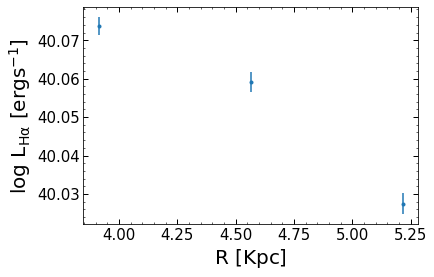

In [238]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
 
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
 
xdata = rad_kpc_ha
ydata = np.log10(phot_Ha)
yerror = phot_Ha_err/phot_Ha/np.log(10)

plt.errorbar(xdata,ydata,yerr = yerror,fmt='.')

# popt, pcov = curve_fit(func, xdata, ydata,sigma=yerror, absolute_sigma=True)
# y2 = [func(i, popt[0],popt[1],popt[2]) for i in xdata]
# plt.plot(xdata,y2,'r--')

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm log\ L_{H\alpha} \ [ergs^{-1}]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
popt

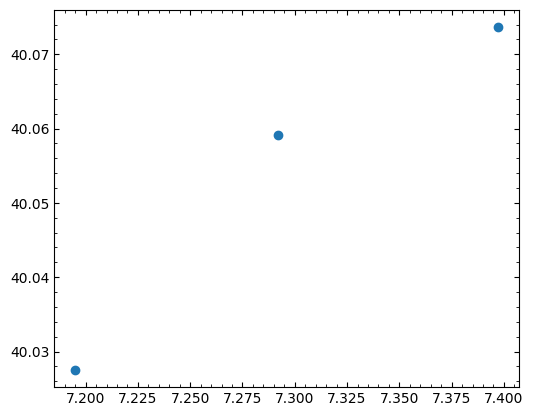

In [242]:
fig = plt.figure(figsize=(6,5),dpi=100)
plt.scatter(stellar_tol,ydata,linestyle='None')

# BPT diagram & map 

In [456]:
Ha_region_data = fits.open('analyse_data_image/SDSSJ0228/SDSSj0228_haregion_flux_rebin.fits')
Hb_region_data = fits.open('analyse_data_image/SDSSJ0228/SDSSj0228_hbregion_flux_rebin.fits')

ha_flux = Ha_region_data[1].data
ha_flux_err = Ha_region_data[2].data
n2_flux = Ha_region_data[3].data
n2_flux_err = Ha_region_data[4].data

hb_flux = Hb_region_data[1].data
hb_flux_err = Hb_region_data[2].data
o3_flux = Hb_region_data[3].data
o3_flux_err = Hb_region_data[4].data

ha_snr = ha_flux/ha_flux_err
snr_cut = np.logical_not(ha_snr<10)

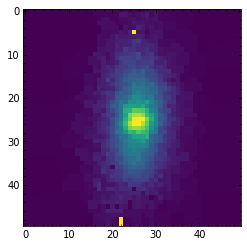

In [457]:
n2_snr = n2_flux/n2_flux_err
plt.imshow(n2_flux,vmin = 3,vmax=800)

In [458]:
flux_Ha_v1 = np.array(ha_flux)*10**(-20)
flux_Hb_v1 = np.array(hb_flux)*10**(-20)
flux_N2_v1 = np.array(n2_flux)*10**(-20)
flux_O3_v1 = np.array(o3_flux)*10**(-20)

NII_xs = np.log10(flux_N2_v1/flux_Ha_v1)
bpt_ys = np.log10(flux_O3_v1/flux_Hb_v1)

NII_x = NII_xs[snr_cut]
bpt_y = bpt_ys[snr_cut]

In [459]:
### 区分BPT region
def bptregion(x, y, mode='N2'):
    '''
    Args:
        lines: dictionary contains all the needed for bpt
            ['Hb-4862', 'OIII-5008','Ha-6564','NII-6585']
      x: log10(NII/Ha) or log10(SII/Ha) or log10(OI/Ha)
      y: log10(OIII/Hb)
      mode: mode "N2" -> x = log10(NII/Ha)
            mode "S2" -> x = log10(SII/Ha)
            mode "O1" -> x = log10(OI/Ha)  ! not surpport yet
    Note:
      x, y should be masked array, 
      example: x = np.ma.array(x)
    '''
    # check starforming, composite or AGN
    # region = np.zeros_like(lines[0].data)
    from numpy.ma import is_masked
    if mode == 'N2':
        ke01 = 0.61/(x-0.47)+1.19
        ka03 = 0.61/(x-0.05)+1.3
        schawinski_line = 1.05*x+0.45
        region_AGN = np.logical_or(np.logical_and(x<0.47, y>ke01), x>0.47)
        region_composite = np.logical_and(y<ke01, y>ka03)
        region_starforming = np.logical_and(x<0.05, y<ka03)
        # depleted
        #region_seyfert = np.logical_and(x>np.log10(0.6), y>np.log10(3.))
        #region_liner = np.logical_and(region_AGN, np.logical_and(x>np.log10(0.6), y<np.log10(3.)))
        # adapted from Schawinski2007
#         region_seyfert = np.logical_and(region_AGN, y>schawinski_line)
#         region_liner = np.logical_and(region_AGN, y<schawinski_line)
        if is_masked(x) or is_masked(y):
            return region_AGN.filled(False), region_composite.filled(False), region_starforming.filled(False), region_seyfert.filled(False), region_liner.filled(False)
        else:
            return region_AGN, region_composite, region_starforming

    if mode == 'S2':
        ke01_line = 0.72/(x-0.32)+1.3
        seyfert_liner_line = 1.89*x+0.76
        region_seyfert = np.logical_and(np.logical_or(y>ke01_line, x>0.32), y>seyfert_liner_line)
        region_liner = np.logical_and(np.logical_or(y>ke01_line, x>0.32), y<seyfert_liner_line)
        region_starforming = np.logical_and(y<ke01_line, x<0.32)
        if is_masked(x) or is_masked(y):
            return region_seyfert.filled(False), region_liner.filled(False), region_starforming.filled(False)
        else:
            return region_seyfert, region_liner, region_starforming

In [460]:
nx = (np.arange(ha_flux.shape[0]) - ha_flux.shape[0]/2)/5.
ny = (np.arange(ha_flux.shape[1]) - ha_flux.shape[1]/2)/5.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')

In [461]:
AGN, CP, SF  = bptregion(NII_xs, bpt_ys, mode='N2')
x_type = np.full_like(xpos, np.nan)
y_type = np.full_like(xpos, np.nan)
x_type[snr_cut] = NII_xs[snr_cut]
y_type[snr_cut] = bpt_ys[snr_cut]
AGN, CP, SF  = bptregion(x_type, y_type, mode='N2')

Text(0, 0.5, 'arcsec')

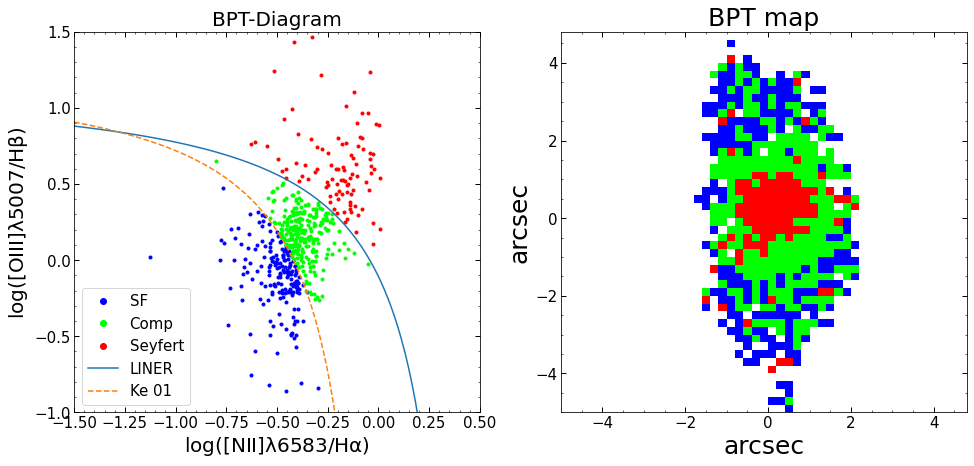

In [464]:
from matplotlib import colors
fig = plt.figure(figsize=(16,7))
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
ax1 = fig.add_subplot(121)

ax1.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax1.set_title('BPT-Diagram',fontsize=20)
ax1.set_xlim(-1.5,0.5)
ax1.set_ylim(-1.0,1.5)

ax1.plot(x_type[SF],y_type[SF],'.',color = 'blue')##SF
ax1.plot(x_type[CP],y_type[CP],'.',color = 'lime')##CP
ax1.plot(x_type[AGN],y_type[AGN],'.',color = 'red')
# ax1.plot(x_type[Lin],y_type[Lin],'.',color = 'orange')##AGN

ax1.set_xlabel(r"$\mathregular{log}(\rm{[NII]\lambda6583/H\alpha})$",fontsize=20)
ax1.set_ylabel(r"$\mathregular{log}(\rm{[OIII]\lambda5007/H\beta})$",fontsize=20)

x1 = np.linspace(-1.5, 0.2, 100)
y_ke01 = 0.61/(x1-0.47)+1.19
ax1.plot(x1,y_ke01)
x2 = np.linspace(-1.5, -.2, 100)
y_ka03 = 0.61/(x2-0.05)+1.3
ax1.plot(x2,y_ka03,'--')
# x3 = np.linspace(-0.18,0.4,100)
# schawinski_line = 1.05*x3+0.45
# ax1.plot(x3,schawinski_line,'-.')

ax1.legend(('SF','Comp','Seyfert','LINER',
         'Ke 01','Ka 03'),
       loc='best',fontsize = 15.0,markerscale = 2)

ax2 = fig.add_subplot(122)
ax2.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax2.set_title(r'BPT map',fontsize=25)
region_type = np.full_like(xpos, np.nan)
region_color = ['red','lime','blue'] 
region_name = ['AGN', 'Comp', 'HII']
#     AGN, CP, SF, *not_need= bptregion(x, y, mode='N2')
region_type[AGN] = 1
region_type[CP] = 2
region_type[SF] = 3
new_region = np.full_like(xpos, np.nan)
new_region[snr_cut] = region_type[snr_cut]

bounds = [0.5, 1.5, 2.5, 3.5] # set color for imshow
cmap = colors.ListedColormap(region_color)
norm = colors.BoundaryNorm(bounds, cmap.N)
# the map data was up-down inverse as the optical image from sdss
ax2.pcolormesh(xpos, ypos, new_region, cmap=cmap, norm=norm)

ax2.set_xlabel('arcsec',fontsize=25)
ax2.set_ylabel('arcsec',fontsize=25)
# plt.savefig('BPT-map-NII.pdf',dpi=600,bbox_inches='tight')

In [28]:
hdr = fits.Header()
hdr['level0'] = 'header'
hdr['level1'] = 'BPT type'
hdr['object'] = 'SDSSJ0228'
hdr['z'] = (0.072,"/ redshift")

empty_primary = fits.PrimaryHDU(header=hdr)
image_hdu1 = fits.ImageHDU(new_region)
        
hdul = fits.HDUList([empty_primary,image_hdu1])
hdul.writeto('data/SDSSJ0228_BPT_type.fits', overwrite=True)
# hdul.writeto('SDSSJ0228_rebinspec_box_O3_8.fits', overwrite=True)

## outflow region BPT diagram


In [2]:
o3_velo_data = fits.open('SDSSJ0228_O3_5007_kine_results.fits')
O3_Sig = fits.open("SDSSJ0228_O3_5007_sigma.fits")

velo_OIII_broad_80 = o3_velo_data[6].data
nan_Or = ~np.isnan(velo_OIII_broad_80)

O3n_sigma     = O3_Sig[1].data
O3n_sigma_err = O3_Sig[2].data
O3b_sigma     = O3_Sig[3].data
O3b_sigma_err = O3_Sig[4].data

rebin_data_Ha = fits.open('analyse_data_image/SDSSJ0228/SDSSJ0228_rebin_specHa_10.fits')
ppdata = fits.open("ppxf/SDSSJ0228/SDSSJ0228_mask_ppxf_fitdata.fits")

pp_wave = ppdata[1].data["wavelength"]
spec_flux = rebin_data_Ha[1].data
spec_err = rebin_data_Ha[2].data

In [11]:
def Ha_model(x,*p):
    f = np.zeros_like(x)
    
    sigma_o = p[3]
    Ha_b_p  = p[0:3]
    Ha_o_p  = p[4:6]
    Ha_n_p  = p[6:9]
    N2a_o_p = p[9:11]
    N2a_n_p = p[11:14]
    N2b_o_p = p[14:16]
    N2b_n_p = p[16:19]
    
    f+= ((Ha_b_p[0] /(Ha_b_p[2] *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-Ha_b_p[1])/Ha_b_p[2]  )**2)+ 
         (Ha_o_p[0] /(sigma_o   *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-Ha_o_p[1])/sigma_o    )**2)+ 
         (Ha_n_p[0] /(Ha_n_p[2] *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-Ha_n_p[1])/Ha_n_p[2]  )**2)+ 
         
         (N2a_o_p[0]/(sigma_o   *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-N2a_o_p[1])/sigma_o   )**2)+ 
         (N2a_n_p[0]/(N2a_n_p[2]*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-N2a_n_p[1])/N2a_n_p[2])**2)+ 
         
         (N2b_o_p[0]/(sigma_o   *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-N2b_o_p[1])/sigma_o   )**2)+ 
         (N2b_n_p[0]/(N2b_n_p[2]*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-N2b_n_p[1])/N2b_n_p[2])**2))
    
    return f


def Hb_model(x,*p):
    f = np.zeros_like(x)
    Hb_b_p  = p[0:3]
    Hb_o_p  = p[3:6]
    Hb_n_p  = p[6:9]
    
    f+= ((Hb_b_p[0]/(Hb_b_p[2] *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-Hb_b_p[1])/Hb_b_p[2])**2)+ 
         (Hb_o_p[0]/(Hb_o_p[2] *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-Hb_o_p[1])/Hb_o_p[2])**2)+ 
         (Hb_n_p[0]/(Hb_n_p[2] *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-Hb_n_p[1])/Hb_n_p[2])**2))
    
    return f

def gaussian(x,*p):
    
    f = np.zeros_like(x)
    for i in range(0, len(p), 3):
        F_aera = p[i]
        xc = p[i+1]
        sigma = p[i+2]
        f += (F_aera /(sigma *np.sqrt(2*np.pi))) * np.exp(-0.5*((x-xc)/sigma)**2)
    
    return f

In [63]:
y,x = 23,25
xc_hb = 4861
xc_ha = 6563
xc_n2a = 6548
xc_n2b = 6583

mask_hb = (pp_wave > 4830) & (pp_wave < 4890)
mask_ha = (pp_wave > 6530) & (pp_wave < 6610)
m_ha = np.where(np.abs(pp_wave - xc_ha) < 5)
m_n2a = np.where(np.abs(pp_wave - xc_n2a) < 5)
m_n2b = np.where(np.abs(pp_wave - xc_n2b) < 5)

F_ha_i = np.nansum(spec_flux[:,y,x][m_ha])
F_hb_i = np.nansum(spec_flux[:,y,x][mask_hb])
F_n2a_i = np.nansum(spec_flux[:,y,x][m_n2a])
F_n2b_i = np.nansum(spec_flux[:,y,x][m_n2b])

sigma_o_i = O3b_sigma[y,x]
sigma_o_i_err = O3b_sigma_err[y,x]
sigma_n_i = O3n_sigma[y,x]
sigma_n_i_err = O3n_sigma_err[y,x]

In [64]:
p_ha = np.array([F_ha_i, 6563, 3, sigma_o_i, F_ha_i, 6563, F_ha_i, 6563, sigma_n_i, 
                 F_n2a_i, 6548, F_n2a_i, 6548, sigma_n_i, F_n2b_i, 6583, F_n2b_i, 6583, sigma_n_i ])

p_ha_bounds = ([0, 6557, 2, sigma_o_i-sigma_o_i_err, 0, 6557, 0, 6557, sigma_n_i-sigma_n_i_err,
                0, 6543, 0, 6543, sigma_n_i-sigma_n_i_err, 0, 6578, 0, 6578, sigma_n_i-sigma_n_i_err],
               [np.inf,  6568, 30, sigma_o_i+sigma_o_i_err, np.inf,  6568, np.inf,  6568, sigma_n_i+sigma_n_i_err, 
                np.inf, 6553, np.inf, 6553, sigma_n_i+sigma_n_i_err, np.inf, 6588, np.inf, 6588, sigma_n_i+sigma_n_i_err])

fit_wave_ha = pp_wave[mask_ha]
fit_spec_ha = spec_flux[:,y,x][mask_ha]
fit_err_ha = spec_err[:,y,x][mask_ha]

popt_ha, pcov_ha = curve_fit(Ha_model, fit_wave_ha, fit_spec_ha, p0=p_ha, bounds=p_ha_bounds,
                                   sigma=fit_err_ha, absolute_sigma=True, maxfev=10000)

chi2 = np.sum((fit_spec_ha - Ha_model(fit_wave_ha, *popt_ha)) ** 2 / fit_err_ha ** 2)
reduced_chi2 = chi2 / (fit_wave_ha.shape[0] - popt_ha.shape[0])
popt_ha,reduced_chi2

(array([1.46188474e+03, 6.56495992e+03, 1.43665353e+01, 3.94408336e+00,
        1.29702246e+03, 6.56298016e+03, 6.47773542e+02, 6.56318986e+03,
        1.38129348e+00, 7.32962485e-10, 6.54300000e+03, 1.42433932e+02,
        6.54851623e+03, 1.34863986e+00, 2.60347417e+01, 6.58631749e+03,
        4.22574904e+02, 6.58396477e+03, 1.38129348e+00]),
 1.3016752240396947)

In [65]:
Ha_bp = popt_ha[0:3]
p_n = np.array(list(popt_ha[6:9]) + list(popt_ha[11:14]) + list(popt_ha[16:19]))
p_o = np.array(list(popt_ha[4:6]) + [popt_ha[3]] + list(popt_ha[9:11]) + [popt_ha[3]] + list(popt_ha[14:16]) + [popt_ha[3]])

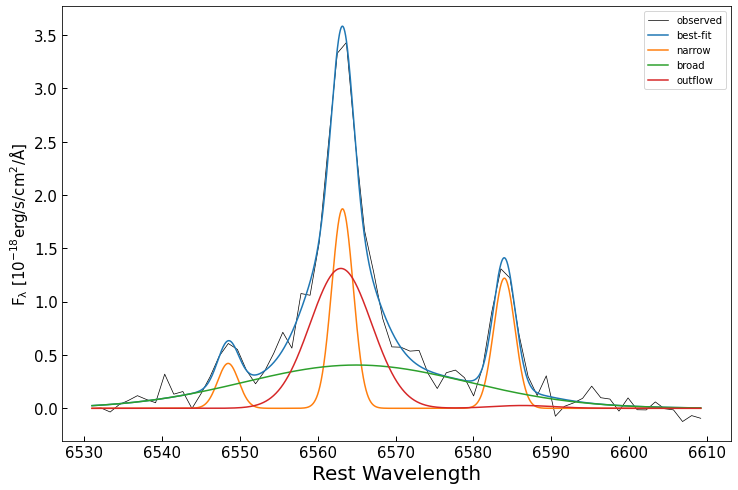

In [66]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Rest Wavelength', fontsize=20)
ax1.set_ylabel(r'${\rm F_\lambda \ [10^{-18}erg/s/cm^2/\AA]}$', fontsize=15)
ax1.tick_params(direction='in', labelsize=15, length=5, width=1.0)

ha_wave   = fit_wave_ha
fake_Hax  = np.arange(ha_wave[0],ha_wave[-1],0.01)
ax1.plot(ha_wave, fit_spec_ha * 10 ** (-2), color='k', lw=0.7, alpha=1, label='observed')
ax1.plot(fake_Hax, Ha_model(fake_Hax, *popt_ha) * 10 ** (-2), label='best-fit')

ax1.plot(fake_Hax, gaussian(fake_Hax, *p_n) * 10 ** (-2), label='narrow')
ax1.plot(fake_Hax, gaussian(fake_Hax, *Ha_bp) * 10 ** (-2), label='broad' )
ax1.plot(fake_Hax, gaussian(fake_Hax, *p_o) * 10 ** (-2), label='outflow')
plt.legend()

In [67]:
p_hb = np.array([F_hb_i, 4861, 5, F_hb_i, 4861, sigma_o_i, F_hb_i, 4861, sigma_n_i ])

p_hb_bounds =([0,  4856, 2, 0, 4856, sigma_o_i-sigma_o_i_err, 0, 4856, sigma_n_i-sigma_n_i_err],
              [np.inf,  4866, 30, np.inf, 4866, sigma_o_i+sigma_o_i_err, np.inf, 4866, sigma_n_i+sigma_n_i_err ])

fit_wave_hb = pp_wave[mask_hb]
fit_spec_hb = spec_flux[:,y,x][mask_hb]
fit_err_hb = spec_err[:,y,x][mask_hb]

popt_hb, pcov_hb = curve_fit(Hb_model, fit_wave_hb, fit_spec_hb, p0=p_hb, bounds=p_hb_bounds,
                                   sigma=fit_err_hb, absolute_sigma=True, maxfev=10000)

chi2 = np.sum((fit_spec_hb - Hb_model(fit_wave_hb, *popt_hb)) ** 2 / fit_err_hb ** 2)
reduced_chi2 = chi2 / (fit_wave_hb.shape[0] - popt_hb.shape[0])
popt_hb,reduced_chi2

(array([3.08253355e+02, 4.85947996e+03, 1.37907588e+01, 5.03281194e+02,
        4.86141741e+03, 2.92149486e+00, 8.94591825e+00, 4.86100745e+03,
        1.16677565e+00]),
 0.740950236841393)

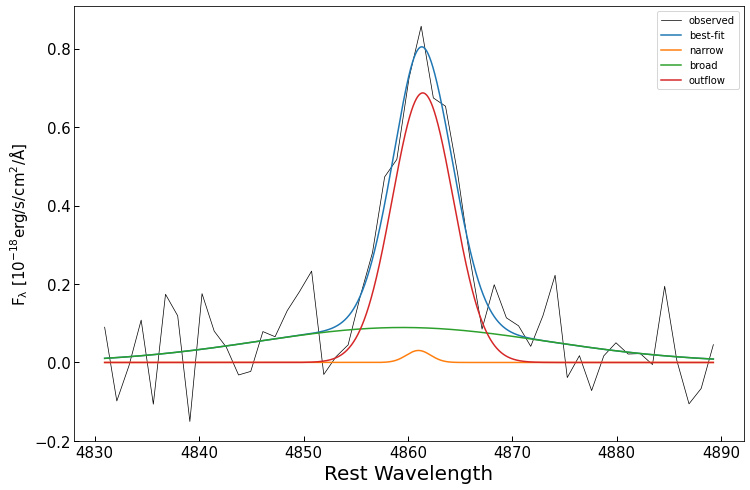

In [68]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Rest Wavelength', fontsize=20)
ax1.set_ylabel(r'${\rm F_\lambda \ [10^{-18}erg/s/cm^2/\AA]}$', fontsize=15)
ax1.tick_params(direction='in', labelsize=15, length=5, width=1.0)

hb_wave   = fit_wave_hb
fake_Hbx  = np.arange(hb_wave[0],hb_wave[-1],0.01)
ax1.plot(hb_wave, fit_spec_hb * 10 ** (-2), color='k', lw=0.7, alpha=1, label='observed')
ax1.plot(fake_Hbx, Hb_model(fake_Hbx, *popt_hb) * 10 ** (-2), label='best-fit')

ax1.plot(fake_Hbx, gaussian(fake_Hbx, *popt_hb[6:9]) * 10 ** (-2), label='narrow')
ax1.plot(fake_Hbx, gaussian(fake_Hbx, *popt_hb[0:3]) * 10 ** (-2), label='broad' )
ax1.plot(fake_Hbx, gaussian(fake_Hbx, *popt_hb[3:6]) * 10 ** (-2), label='outflow')

plt.legend()

In [29]:
o3_flux_data = fits.open('SDSSJ0228_O3_flux.fits')
o3_velo_data = fits.open('SDSSJ0228_O3_5007_kine_results.fits')
Ha_region_data = fits.open('analyse_data_image/SDSSJ0228/SDSSj0228_haregion_flux_rebin.fits')
Hb_region_data = fits.open('analyse_data_image/SDSSJ0228/SDSSj0228_hbregion_flux_rebin.fits')

velo_OIII_broad_80 = o3_velo_data[6].data
flux_OIII_narrow = o3_flux_data[2].data
flux_OIII_narrow_err = o3_flux_data[4].data
flux_OIII_broad  = o3_flux_data[6].data
flux_OIII_broad_err = o3_flux_data[8].data

ha_flux = Ha_region_data[1].data
ha_flux_err = Ha_region_data[2].data
n2_flux = Ha_region_data[3].data
n2_flux_err = Ha_region_data[4].data

hb_flux = Hb_region_data[1].data
hb_flux_err = Hb_region_data[2].data

nan_Or = np.isnan(velo_OIII_broad_80)
flux_hb_new = hb_flux
flux_hb_new[nan_Or] = np.nan
flux_ha_new = ha_flux
flux_ha_new[nan_Or] = np.nan
flux_n2_new = n2_flux
flux_n2_new[nan_Or] = np.nan

ha_snr = ha_flux/ha_flux_err
snr_cut = np.logical_not(ha_snr<10)

In [472]:
N2_Ha = np.log10(flux_n2_new/flux_ha_new)
O3_Hb = np.log10(flux_OIII_broad/flux_hb_new)
AGN, CP, SF  = bptregion(N2_Ha, O3_Hb, mode='N2')

nx = (np.arange(50) - 50/2)/5.
ny = (np.arange(50) - 50/2)/5.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')
x_type = np.full_like(xpos, np.nan)
y_type = np.full_like(ypos, np.nan)
x_type = N2_Ha
y_type = O3_Hb

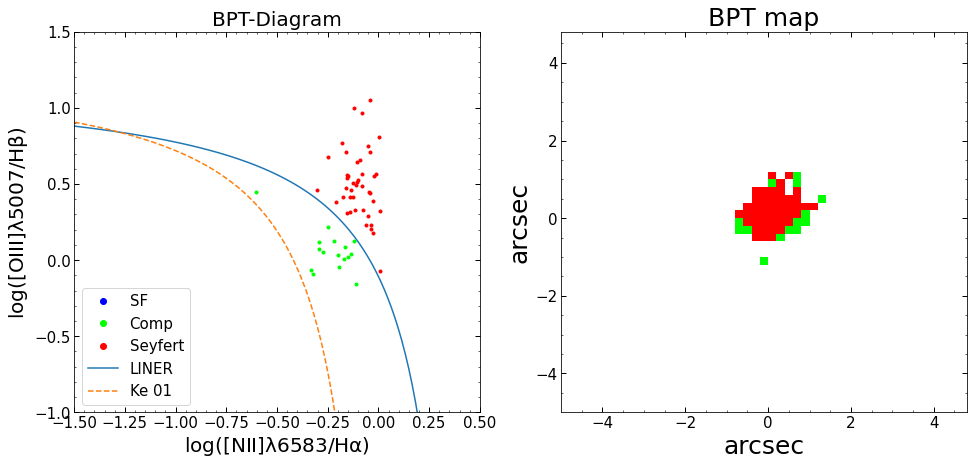

In [474]:
from matplotlib import colors
fig = plt.figure(figsize=(16,7))
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
ax1 = fig.add_subplot(121)

ax1.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax1.set_title('BPT-Diagram',fontsize=20)
ax1.set_xlim(-1.5,0.5)
ax1.set_ylim(-1.0,1.5)

ax1.plot(x_type[SF],y_type[SF],'.',color = 'blue')##SF
ax1.plot(x_type[CP],y_type[CP],'.',color = 'lime')##CP
ax1.plot(x_type[AGN],y_type[AGN],'.',color = 'red')

ax1.set_xlabel(r"$\mathregular{log}(\rm{[NII]\lambda6583/H\alpha})$",fontsize=20)
ax1.set_ylabel(r"$\mathregular{log}(\rm{[OIII]\lambda5007/H\beta})$",fontsize=20)

x1 = np.linspace(-1.5, 0.2, 100)
y_ke01 = 0.61/(x1-0.47)+1.19
ax1.plot(x1,y_ke01)
x2 = np.linspace(-1.5, -.2, 100)
y_ka03 = 0.61/(x2-0.05)+1.3
ax1.plot(x2,y_ka03,'--')

ax1.legend(('SF','Comp','Seyfert','LINER',
         'Ke 01','Ka 03'),
       loc='lower left',fontsize = 15.0,markerscale = 2)

ax2 = fig.add_subplot(122)
ax2.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax2.set_title(r'BPT map',fontsize=25)
region_type = np.full_like(xpos, np.nan)
region_color = ['red','lime','blue'] 
region_name = ['AGN', 'Comp', 'HII']
#     AGN, CP, SF, *not_need= bptregion(x, y, mode='N2')
region_type[AGN] = 1
region_type[CP] = 2
region_type[SF] = 3
new_region = np.full_like(xpos, np.nan)
new_region[snr_cut] = region_type[snr_cut]

bounds = [0.5, 1.5, 2.5, 3.5] # set color for imshow
cmap = colors.ListedColormap(region_color)
norm = colors.BoundaryNorm(bounds, cmap.N)
# the map data was up-down inverse as the optical image from sdss
ax2.pcolormesh(xpos, ypos, new_region, cmap=cmap, norm=norm)

ax2.set_xlabel('arcsec',fontsize=25)
ax2.set_ylabel('arcsec',fontsize=25)

plt.savefig('BPT-map-NII_OR.pdf',dpi=600,bbox_inches='tight')

# spatial resolved properties

In [339]:
####  white image

from astropy import wcs
from astropy.wcs import WCS
import matplotlib.patches as patches

sdssj0228 = fits.open("data/SDSSJ022849.51-090153.8.fits",memmap = True)
spec_data = sdssj0228[1].data
image_wihte = np.nansum(spec_data,axis=0)

header_0228 = sdssj0228[1].header
wcs1 = WCS(header_0228)

wcs_new = wcs.WCS(naxis=2)
wcs_new.wcs.crpix = [159,156]
wcs_new.wcs.crval = np.array([37.206292,-9.03161])
wcs_new.wcs.cdelt = np.array([-5.55555555555556e-05, 5.55555555555556e-05]) #minus for left-east
wcs_new.wcs.ctype = ['RA---TAN', 'DEC--TAN']

wcs_new.pixel_to_world(142+25,162+25)

<SkyCoord (ICRS): (ra, dec) in deg
    (37.20578573, -9.02983222)>

In [379]:
###  O3 flux & V
from plotbin.display_pixels import display_pixels
o3_flux_data = fits.open('SDSSJ0228_O3_flux.fits')
o3_velo_data = fits.open('SDSSJ0228_O3_5007_kine_results.fits')

flux_OIII_narrow = o3_flux_data[2].data
flux_OIII_narrow_err = o3_flux_data[4].data
flux_OIII_broad  = o3_flux_data[6].data
flux_OIII_broad_err = o3_flux_data[8].data

flux_OIII_narrow[np.isnan(flux_OIII_narrow)] = 0
flux_OIII_broad[np.isnan(flux_OIII_broad)] = 0
flux_O3_t = (flux_OIII_narrow + flux_OIII_broad) *10**(0.40-3)

velo_OIII_broad_50 = o3_velo_data[2].data
velo_OIII_broad_80 = o3_velo_data[6].data

nx = (np.arange(flux_OIII_narrow.shape[1]) - flux_OIII_narrow.shape[0]/2)/5.
ny = (np.arange(flux_OIII_narrow.shape[0]) - flux_OIII_narrow.shape[1]/2)/5.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')
snr_cut = np.logical_not(ha_snr<10)

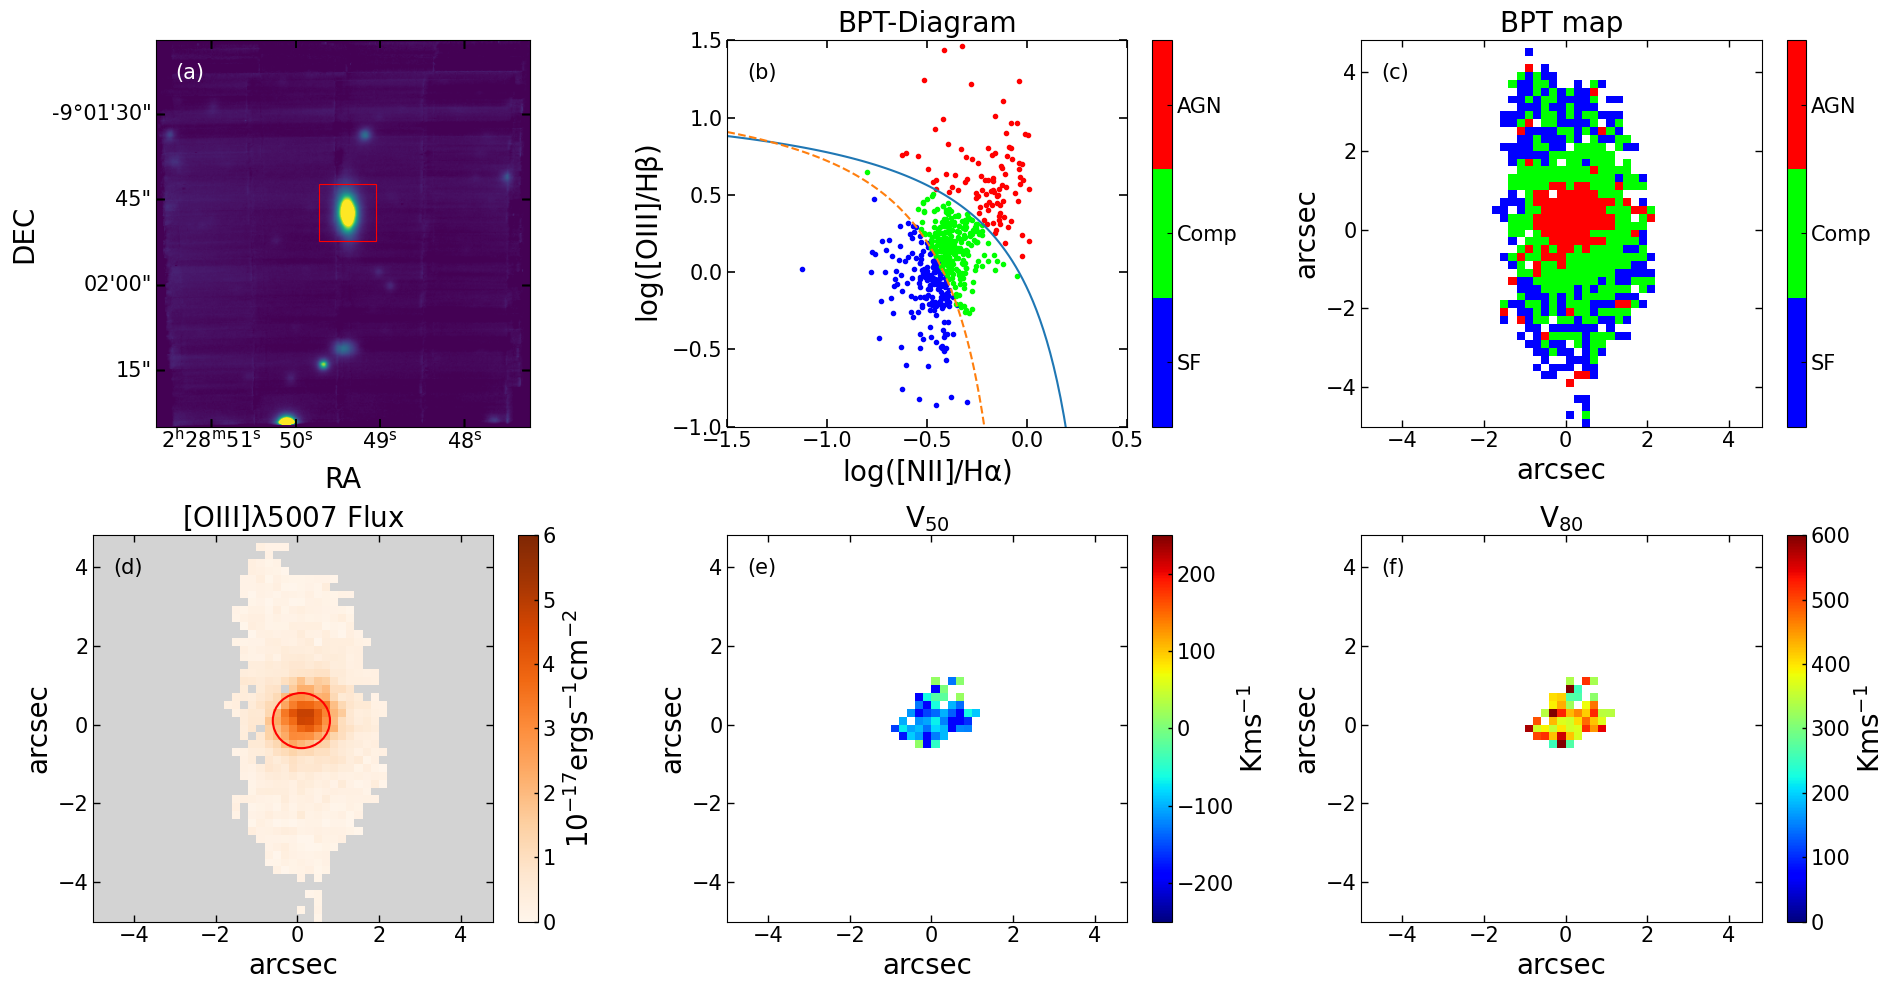

In [441]:
fig = plt.figure(figsize=(19,10),dpi=100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = False
plt.rcParams["ytick.minor.visible"] = False

title_size = 20
ls = 15

ax_whimg = fig.add_subplot(231,projection=wcs_new)

ax_whimg.set_xlabel('RA',fontsize = title_size)
ax_whimg.set_ylabel('DEC',fontsize = title_size)
ax_whimg.tick_params(direction='in', labelsize = ls, length = 6, width=1.2)

ax_whimg.imshow(image_wihte, origin='lower', cmap=plt.cm.viridis,vmin=100,vmax=110000)
rect1 = patches.Rectangle((142, 162),50,50,linewidth=0.8,edgecolor='red',facecolor='none')
ax_whimg.add_patch(rect1)
ax_whimg.text(0.05,0.9,'(a)',transform=ax_whimg.transAxes,fontdict={'size': '15', 'color': 'white'})


ax_bptn   = fig.add_subplot(232)

ax_bptn.set_title('BPT-Diagram',fontsize = title_size)
ax_bptn.set_xlabel(r"$\mathregular{log}(\rm{[NII]/H\alpha})$",fontsize=title_size)
ax_bptn.set_ylabel(r"$\mathregular{log}(\rm{[OIII]/H\beta})$",fontsize=title_size)
ax_bptn.tick_params(direction='in', labelsize = ls, length = 6, width=1.2)
ax_bptn.set_xlim(-1.5,0.5)
ax_bptn.set_ylim(-1.0,1.5)
ax_bptn.text(0.05,0.9,'(b)',transform=ax_bptn.transAxes,fontdict={'size': '15', 'color': 'black'})

ax_bptn.plot(x_type[SF],y_type[SF],'.',color = 'blue')##SF
ax_bptn.plot(x_type[CP],y_type[CP],'.',color = 'lime')##CP
ax_bptn.plot(x_type[AGN],y_type[AGN],'.',color = 'red')##AGN

x1 = np.linspace(-1.5, 0.2, 100)
y_ke01 = 0.61/(x1-0.47)+1.19
ax_bptn.plot(x1,y_ke01)
x2 = np.linspace(-1.5, -.2, 100)
y_ka03 = 0.61/(x2-0.05)+1.3
ax_bptn.plot(x2,y_ka03,'--')

# ax_bptn.legend(('SF','Comp','AGN',
#          'Ke 01','Ka 03'),
#        loc='lower right',fontsize = 10,markerscale = 1)
cb = plt.colorbar(ax_bptm,ticks = np.array([1,2,3]))
cb.ax.set_yticklabels(region_name,fontdict={'size': '15', 'color': 'black'})

ax_bptm   = fig.add_subplot(233)

ax_bptm.tick_params(direction='in', labelsize = ls, length = 5, width=1.0)
ax_bptm.set_title(r'BPT map',fontsize=title_size)
ax_bptm.set_xlabel('arcsec',fontsize=title_size)
ax_bptm.set_ylabel('arcsec',fontsize=title_size)
ax_bptm.text(0.05,0.9,'(c)',transform=ax_bptm.transAxes,fontdict={'size': '15', 'color': 'black'})

region_type = np.full_like(xpos, np.nan)
region_color = ['blue','lime','red'] 
region_name = ['SF', 'Comp', 'AGN']
region_type[AGN] = 3
region_type[CP] = 2
region_type[SF] = 1
new_region = np.full_like(xpos, np.nan)
new_region[snr_cut] = region_type[snr_cut]
bounds = [0.5, 1.5, 2.5, 3.5] # set color for imshow
cmap = colors.ListedColormap(region_color)
norm = colors.BoundaryNorm(bounds, cmap.N)
ax_bptm = plt.pcolormesh(xpos, ypos, new_region, cmap=cmap, norm=norm)
cb = plt.colorbar(ax_bptm,ticks = np.array([1,2,3]))
cb.ax.set_yticklabels(region_name,fontdict={'size': '15', 'color': 'black'})


ax_O3f    = fig.add_subplot(234)

ax_O3f.set_facecolor('lightgray')

ax_O3f.set_title(r'${\rm [OIII] \lambda 5007\ Flux}$',fontsize = title_size)
ax_O3f.text(0.05,0.9,'(d)',transform=ax_O3f.transAxes,fontdict={'size': '15', 'color': 'black'})
ax_O3f.tick_params(direction='in', labelsize = ls, length = 5, width=1.0)
ax_O3f.set_xlabel('arcsec',fontsize=title_size)
ax_O3f.set_ylabel('arcsec',fontsize=title_size)

cir1 = Circle(xy = (0.1, 0.1), radius=0.2*3.5, linestyle = '-',edgecolor = 'r',fc = 'none',lw = 1.5)
ax_O3f.add_patch(cir1)

flux_o3n = np.full_like(flux_O3_t,np.nan)
flux_o3n[snr_cut] = flux_O3_t[snr_cut]
ax_O3f = plt.pcolormesh(xpos, ypos, flux_o3n,vmin=0,vmax=6,cmap='Oranges')
cb = plt.colorbar(ax_O3f)
cb.ax.tick_params(direction='in', labelsize = ls, length = 3, width=1.0)
cb.set_label(r'${\rm 10^{-17}ergs^{-1}cm^{-2}}$',fontsize = title_size)





ax_outlv = fig.add_subplot(235)

ax_outlv.set_title(r'${\rm V_{50}}$',fontsize = title_size)
ax_outlv.set_xlabel('arcsec',fontsize = title_size)
ax_outlv.set_ylabel('arcsec',fontsize = title_size)
ax_outlv.tick_params(direction='in', labelsize = ls, length = 5, width=1.0)
ax_outlv.text(0.05,0.9,'(e)',transform=ax_outlv.transAxes,fontdict={'size': '15', 'color': 'black'})
o3_v50 = np.full_like(velo_OIII_broad_50,np.nan)
o3_v50[region_selet] = velo_OIII_broad_50[region_selet]
o3_v50[19,24] = np.nan

ax_outlv = plt.pcolormesh(xpos, ypos, o3_v50,vmin=-250,vmax=250,cmap='jet')

cb = plt.colorbar(ax_outlv)
cb.ax.tick_params(direction='in', labelsize = ls, length = 3, width=1.0)
cb.set_label(r'${\rm Kms^{-1}}$',fontsize = title_size)

ax_outv  = fig.add_subplot(236)

ax_outv.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax_outv.set_title(r'${\rm V_{80}}$',fontsize = title_size)
ax_outv.set_xlabel('arcsec',fontsize = title_size)
ax_outv.set_ylabel('arcsec',fontsize = title_size)
ax_outv.text(0.05,0.9,'(f)',transform=ax_outv.transAxes,fontdict={'size': '15', 'color': 'black'})

o3_v80 = np.full_like(velo_OIII_broad_80,np.nan)
o3_v80[region_selet] = velo_OIII_broad_80[region_selet]
o3_v80[19,24] = np.nan
ax_outv = plt.pcolormesh(xpos, ypos, o3_v80,vmin=0,vmax=600,cmap='jet')

cb = plt.colorbar(ax_outv)
cb.ax.tick_params(direction='in', labelsize = ls, length = 3, width=1.0)
cb.set_label(r'${\rm Kms^{-1}}$',fontsize = title_size)

plt.tight_layout()
# plt.savefig('spatial_resolved_image.pdf',dpi=600,bbox_inches='tight')

# generate error


In [644]:
### 根据给定光谱和误差，按误差的高斯分布随机产生新的光谱
def generate_spectra(flux,error):
    import random
    if flux.shape[0] == error.shape[0]:
        pass
    else:
        print('flux and error must be same shape !')
        
    random_spec = []
    for i in range(flux.shape[0]):
        mu_flux = flux[i]
        sigma_flux = error[i]
        random_spec_i = random.gauss(mu_flux,sigma_flux)
        random_spec.append(random_spec_i)
    return random_spec

In [681]:
star_mass = ascii.read('data/Sigma_star_10kpc.txt')
SD_star = star_mass['density_total']
SD_star_error = star_mass['density_total_error']
SD_disk = star_mass['density_disc']
SD_disk_error = star_mass['density_disc_error']
SD_bulge = star_mass['density_bulge']
SD_bulge_error = star_mass['density_bulge_error']
SD_bulge_error[np.isnan(SD_bulge_error)] = 0.6

SD_radii = star_mass['R(kpc)']
SD_r = np.around(SD_radii,decimals=2)

gas_mass = ascii.read('data/gasmass_surface_density_2model.txt')
SD_gas_ep = gas_mass['SD_GAS_ep']
SD_gas_ep_error = gas_mass['SD_GAS_ep_err']
SD_gas_ep_error[np.isnan(SD_gas_ep_error)] = 9.0
SD_gas_disk = gas_mass['SD_GAS_disk']
SD_gas_disk_error = gas_mass['SD_GAS_disk_err']
SD_gas_disk_error[np.isnan(SD_gas_disk_error)] = 9.0

In [646]:
# SD_star_rd = {}
# for i in np.arange(1000):
#     SD_star_rd['SDstar_'+str(i)] = generate_spectra(SD_star,SD_star_error)
    
# rdd = Table(SD_star_rd)
# ascii.write(rdd,'data/SD_star_random_ex.txt',overwrite=1)

In [682]:
SD_disk_rd = {}
SD_disk_rd['R'] = SD_r
for i in np.arange(1000):
    sd_disc = generate_spectra(SD_disk,SD_disk_error)
    SD_disk_rd['SDstar_disk_'+str(i)] = np.around(sd_disc, decimals=2)
    
rdd = Table(SD_disk_rd)
ascii.write(rdd,'data/SD_star_disk_random_ex.txt',overwrite=1)

In [683]:
SD_bulge_rd = {}
SD_bulge_rd['R'] = SD_r
for i in np.arange(1000):
    sd_bulge = generate_spectra(SD_bulge,SD_bulge_error)
    SD_bulge_rd['SDstar_bulge_'+str(i)] = np.around(sd_bulge, decimals=2)
    
rdd = Table(SD_bulge_rd)
ascii.write(rdd,'data/SD_star_bulge_random_ex.txt',overwrite=1)

In [684]:
SD_gas_rd = {}
SD_gas_rd['R'] = SD_r[:-2]
for i in np.arange(1000):
    sd_gas = generate_spectra(SD_gas_ep,SD_gas_ep_error)
    SD_gas_rd['SDgas_'+str(i)] = np.around(sd_gas, decimals=2)
    
rdd = Table(SD_gas_rd)
ascii.write(rdd,'data/SD_gas_ep_random.txt',overwrite=1)

In [685]:
SD_gas_rd = {}
SD_gas_rd['R'] = SD_r[:-2]
for i in np.arange(1000):
    sd_gas = generate_spectra(SD_gas_disk,SD_gas_disk_error)
    SD_gas_rd['SDgas_'+str(i)] = np.around(sd_gas, decimals=2)
    
rdd = Table(SD_gas_rd)
ascii.write(rdd,'data/SD_gas_disc_random.txt',overwrite=1)

# roration curve

In [80]:
rc_data = ascii.read('analyse_data_image/SDSSJ0228/rotation_curve_error_v1.txt')

R_star_mask = np.where(R_star<6)
bulge_v = rc_data['rc_bulge_v'][R_star_mask]
bulge_v_err = rc_data['rc_bulge_err'][R_star_mask]
disk_v = rc_data['rc_disk_v'][R_star_mask]
disk_v_err = rc_data['rc_disk_err'][R_star_mask]
gas_v = rc_data['rc_gas_v'][R_star_mask]
gas_v_err = rc_data['rc_gas_err'][R_star_mask] 

star_v = np.sqrt(bulge_v**2 + disk_v**2)
star_v_err = np.sqrt((bulge_v_err*bulge_v/star_v)**2+(disk_v_err*disk_v/star_v)**2)

baron_v = np.sqrt(star_v**2 + gas_v**2)
baron_v_err = np.sqrt((star_v_err*star_v/baron_v)**2+(gas_v_err*gas_v/baron_v)**2)

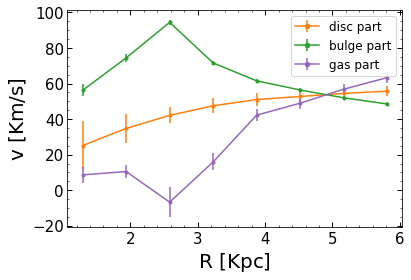

In [55]:
###  disc and bulge

plt.errorbar(R_star[R_star_mask],disk_v,yerr=disk_v_err,fmt='C1.-',label ='disc part')
plt.errorbar(R_star[R_star_mask],bulge_v,yerr=bulge_v_err,fmt='C2.-',label ='bulge part')
plt.errorbar(R_star[R_star_mask],gas_v,yerr=gas_v_err,fmt='C4.-',label = 'gas part')

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm v\ [Km/s]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
plt.legend(fontsize = 12.0,markerscale = 1.5)

In [76]:
v_ha_data = ascii.read('analyse_data_image/SDSSJ0228/Ha_rotataion_velocity.txt')
v_O3_data = ascii.read('analyse_data_image/SDSSJ0228/OIII_outflow_velocity.txt')
radius_O3 = v_O3_data['R(kpc)']
v50_O3 = v_O3_data['v50_O3_broad']
v50_O3_err = v_O3_data['v50_O3_broad_error']
v80_O3 = v_O3_data['v80_O3_broad']
v80_O3_err = v_O3_data['v80_O3_broad_error']

(-20.0, 180.0)

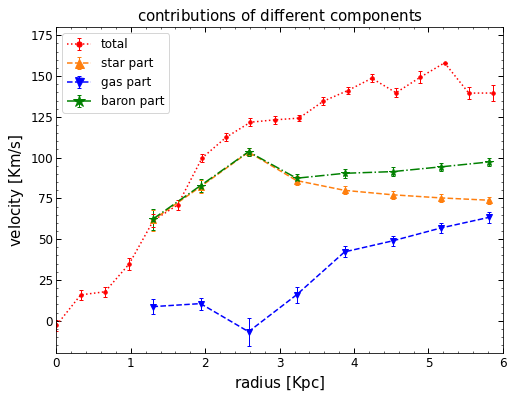

In [81]:
from astropy.io import ascii
from astropy.table import Table
v_ha_data = ascii.read('analyse_data_image/SDSSJ0228/Ha_rotataion_velocity.txt')
dist = 335.8 
snr_x = np.arange(-25,25,1)
snr_mask = np.where(np.abs(snr_x)<19)
kpc_perpix = (0.2/2.06e5)*dist*1.0e3
radius = np.array(v_ha_data['R(kpc)'])[snr_mask]*(kpc_perpix/0.3) 
radii = radius[0:radius.shape[0]:2]
v_ha = np.array(v_ha_data['v_Ha_ro'])[snr_mask]
v_ha_err = np.array(v_ha_data['v_Ha_ro_error'])[snr_mask]

v_circ_data = ascii.read('analyse_data_image/SDSSJ0228/asymmetric_draft_correction.txt')
v_circ = v_circ_data["v_circ"]
v_circ_err = v_circ_data["v_circ_err"]

# Ha_v = v_ha[0:v_ha.shape[0]:2]
# Ha_v_err = v_ha_err[0:v_ha_err.shape[0]:2]

plt.figure(figsize=(8,6))
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

plt.errorbar(radius,v_ha,yerr=v_ha_err,fmt='r.:',elinewidth=1,ms=7,capsize=2,label='total')
plt.errorbar(R_star[R_star_mask],star_v,yerr=star_v_err,fmt='C1^--',elinewidth=1,ms=6,capsize=2,label = 'star part')
plt.errorbar(R_star[R_star_mask],gas_v,yerr=gas_v_err,fmt='bv--',elinewidth=1,ms=6,capsize=2,label = 'gas part')
plt.errorbar(R_star[R_star_mask],baron_v,yerr=baron_v_err,fmt='g*-.',elinewidth=1,ms=8,capsize=2,label ='baron part')

# plt.errorbar(radius_O3,np.abs(v50_O3),yerr=v50_O3_err,fmt='C4o',elinewidth=3,ms=5,label='v50')
# plt.errorbar(radius_O3,np.abs(v80_O3),yerr=v80_O3_err,fmt='>',elinewidth=3,ms=5,label='v80')

plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
plt.ylabel(r'${\rm velocity\ [Km/s]}$',fontsize=15)
plt.xlabel(r'${\rm radius\ [Kpc]}$',fontsize=15)
plt.title(r'${\rm contributions\ of\ different\ components}$',fontsize=15)
plt.legend(fontsize = 12.0,markerscale = 1.5)
plt.xlim(0,6)
plt.ylim(-20,180)

# plt.savefig("rotation-curve_different_part.pdf",dpi=600)

In [82]:
half_gn0 = np.logical_not(radius<0)
half_ln0 = np.where(radius<0)
v_ha_gn0_log = np.log10(np.abs(v_ha[half_gn0]))
v_ha_ln0_log = -np.log10(np.abs(v_ha[half_ln0]))
v_ha_log_v1 = [v_ha_ln0_log,v_ha_gn0_log]
v_ha_log = [y for x in v_ha_log_v1 for y in x]
v_ha_err_log = np.sqrt(v_ha_err**2/v_ha**2)/(np.log(10))

log_v_circ = np.log10(v_circ)
log_v_circ_err = np.sqrt(v_circ_err**2/v_circ**2)/(np.log(10))

radius_O3 = v_O3_data['R(kpc)']
v50_O3 = v_O3_data['v50_O3_broad']
v50_O3_err = v_O3_data['v50_O3_broad_error']
v50_O3_log = -np.log10(np.abs(v50_O3))
v50_O3_err_log = np.sqrt(v50_O3_err**2/v50_O3**2)/(np.log(10))
v80_O3 = v_O3_data['v80_O3_broad']
v80_O3_err = v_O3_data['v80_O3_broad_error']
v80_O3_log = -np.log10(np.abs(v80_O3))
v80_O3_err_log = np.sqrt(v80_O3_err**2/v80_O3**2)/(np.log(10))

star_v_log = np.log10(star_v)
star_v_err_log = np.sqrt(star_v_err**2/star_v**2)/(np.log(10))
bar_v_log = np.log10(baron_v)
bar_v_err_log = np.sqrt(baron_v_err**2/baron_v**2)/(np.log(10))
gas_v_log = np.log10(np.abs(gas_v))
gas_v_err_log = np.sqrt(gas_v_err**2/gas_v**2)/(np.log(10))

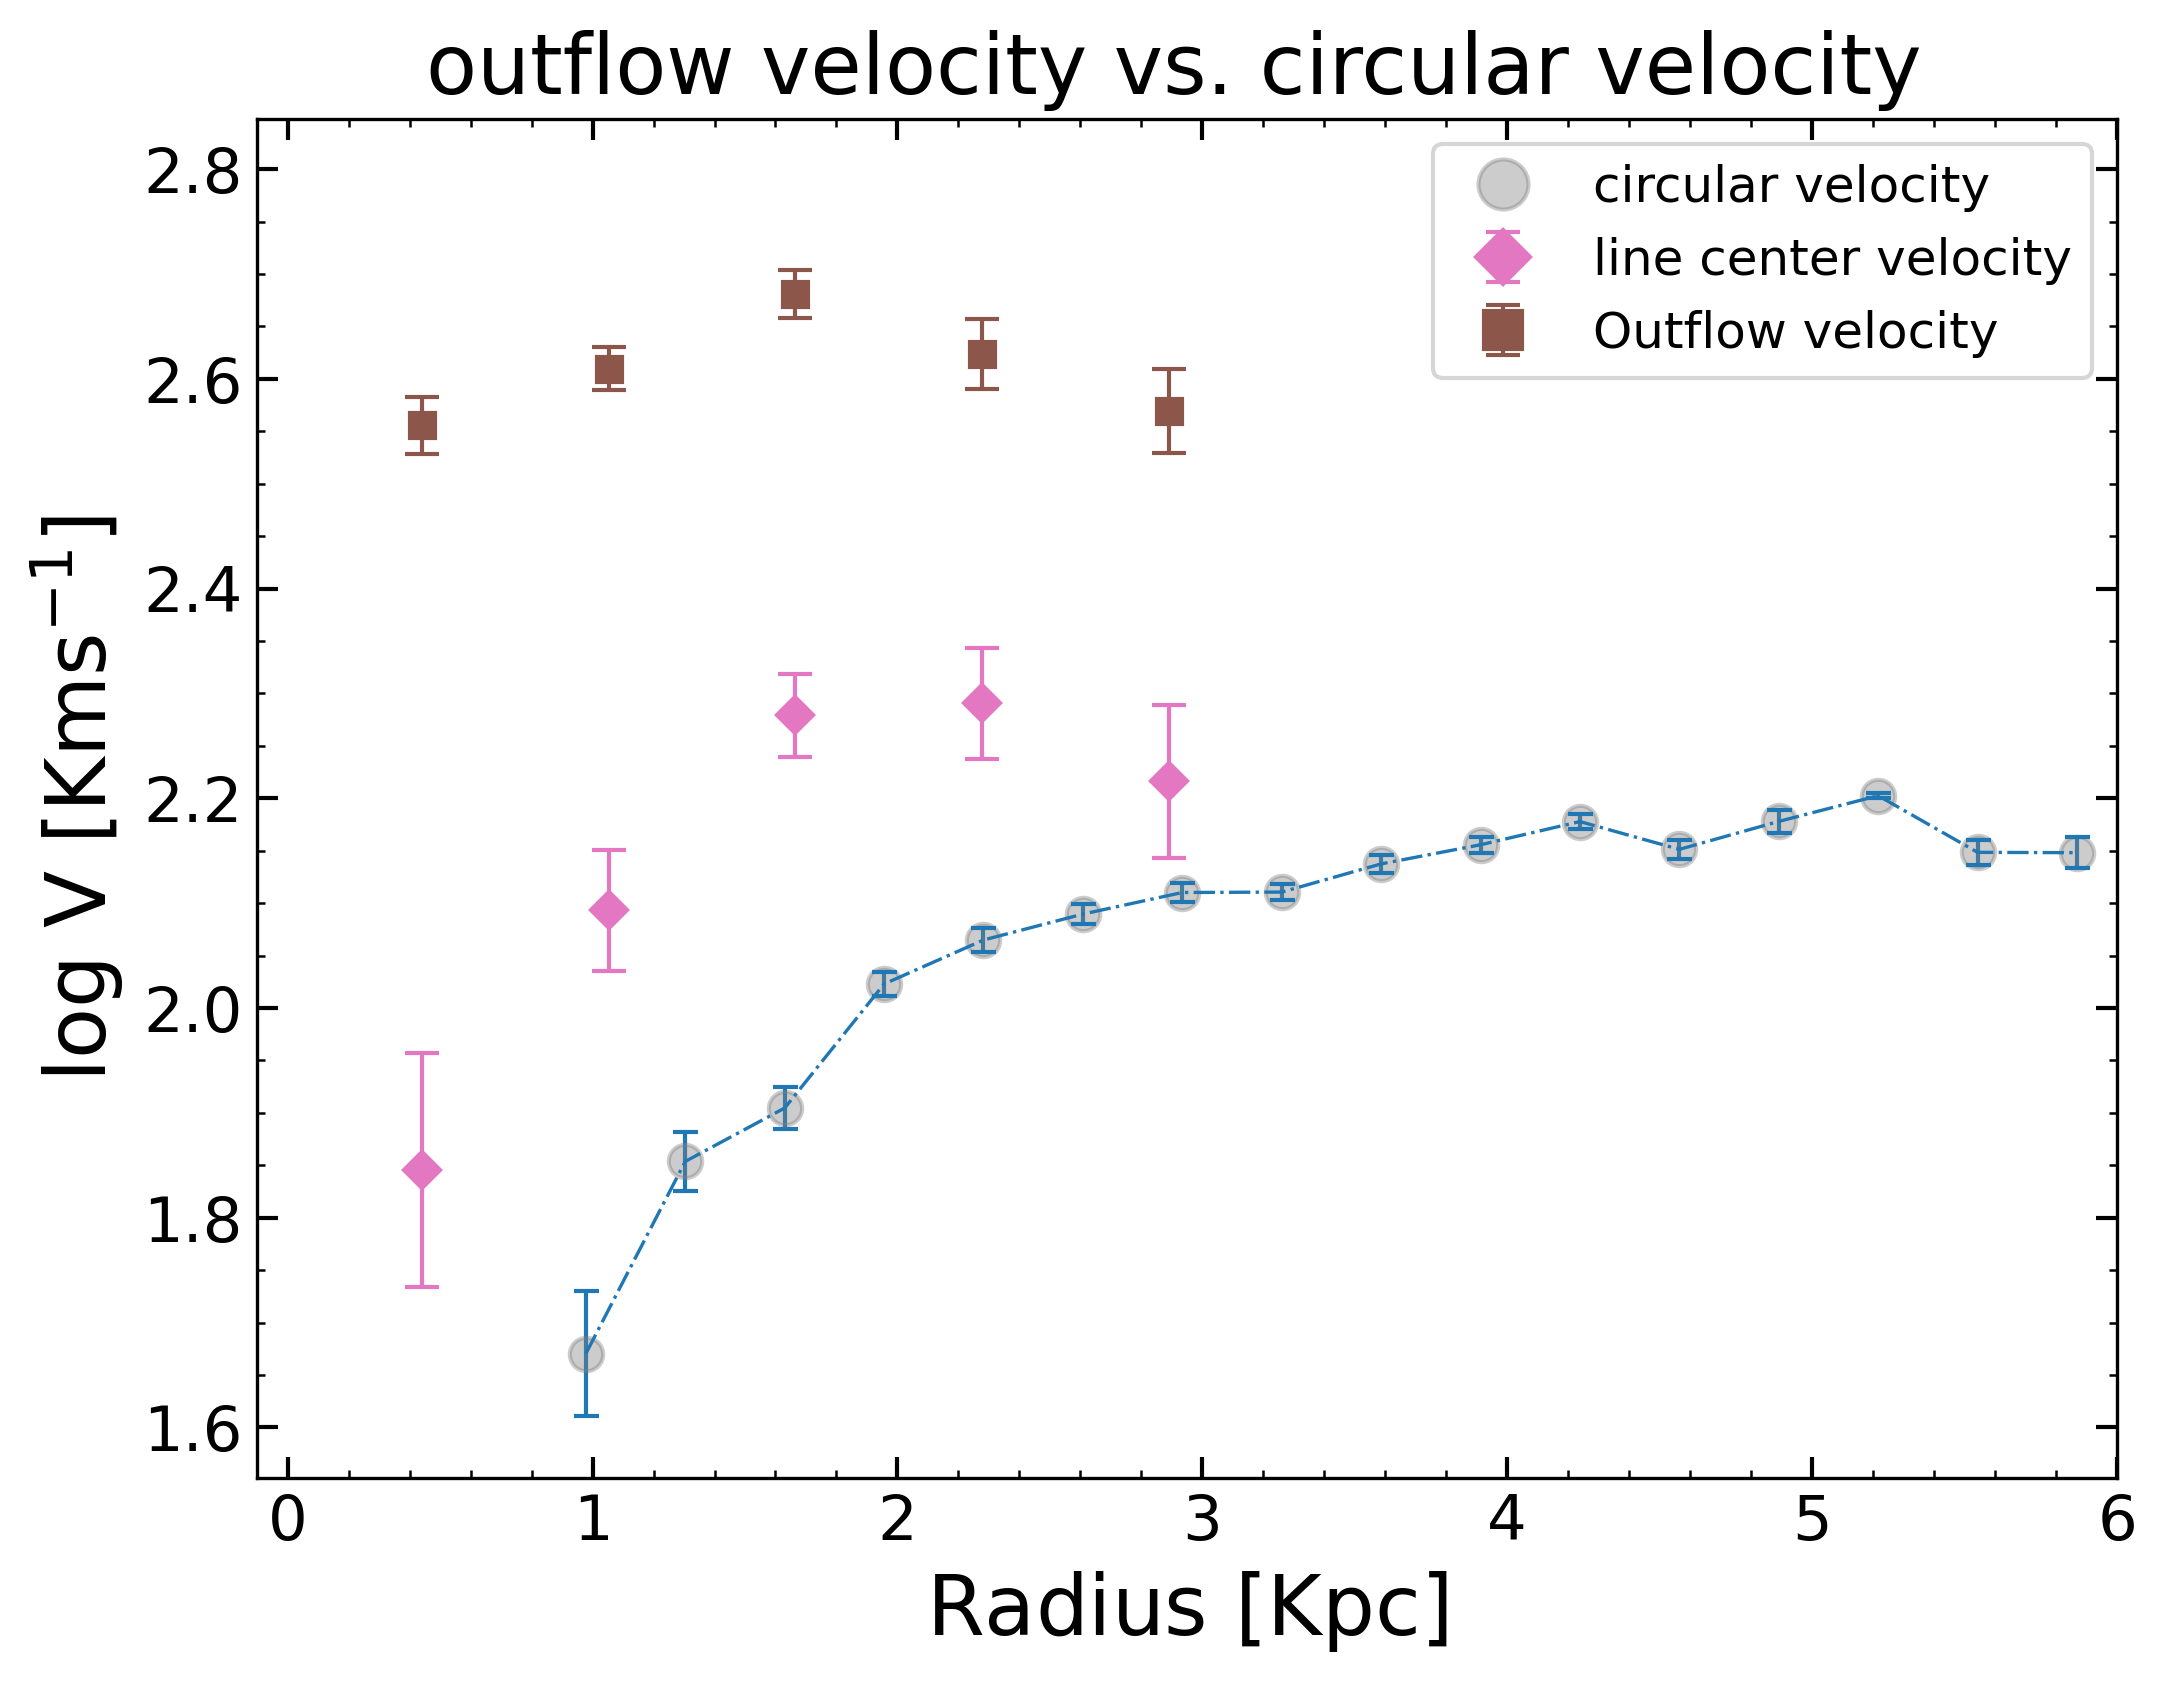

In [331]:
plt.figure(figsize=(8,6),dpi = 300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.plot(radius[21:],log_v_circ,c='gray',marker='o',ms=8,label='circular velocity',linestyle="None",alpha=0.4)
plt.errorbar(radius[21:],log_v_circ,yerr = log_v_circ_err,
             ms=9,mfc = 'C0',mec = 'C0',fmt = '-.',color = 'C0',lw = 0.8,
             capsize=3,elinewidth=1,ecolor = 'C0')

plt.errorbar(radius_O3+0.44,np.abs(v50_O3_log),yerr=v50_O3_err_log,fmt='C6D',elinewidth=1,ms=6,capsize=4,label='line center velocity')
plt.errorbar(radius_O3+0.44,np.abs(v80_O3_log),yerr=v80_O3_err_log,fmt='C5s',elinewidth=1,ms=6,capsize=4,label='Outflow velocity')

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm log\ V\ [Kms^{-1}]}$',fontsize=20)
plt.xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=20)
plt.title(r'outflow velocity vs. circular velocity ',fontsize=20)
plt.legend(fontsize = 12.0,markerscale = 1.5)
plt.xlim(-1e-1,6)
# plt.ylim(-20,260)
plt.savefig("outflow vs rotation-curve_log.pdf",dpi=600,bbox_inches = 'tight')

## save data

In [ ]:
# ###  保存数据
# rc_bulge = np.around(bulge_v, decimals=4)
# rc_disc = np.around(disc_v, decimals=4)
# rc_radius = np.around(rad_kpc_r, decimals=4)
# rc_total = np.around(v, decimals=4)
# rdd=Table({'R_total(kpc)':rc_radius,
#            'velocity_bulge':rc_bulge,
#            'velocity_disc':rc_disc,
#            'velocity_total':rc_total,})
# ascii.write(rdd,'analyse_data_image/SDSSJ0228/stellar_part_rotation_velocity.txt',overwrite=1)